# Face Generation
In this project, I used generative adversarial networks to generate new images of faces.
### Get the Data
I will be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [51]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

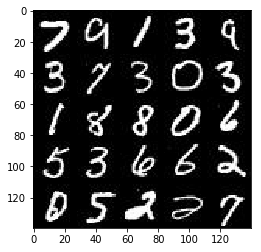

In [52]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

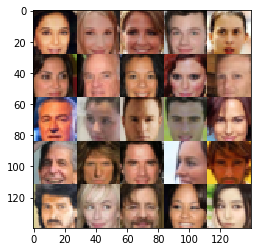

In [53]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
I'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [54]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Here I Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [55]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    #Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 
                                 name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Here I Implement the `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [56]:
def discriminator(images, reuse=False):
    
        
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Implement Function
        alpha = 0.2
        
        #input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * x3, x3)
        #7x7x256
        
        #flatten and pass through fully connected layer to activation funcion
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Here I Implement the `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [57]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
        # Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        #First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        #Reshape to start convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #14x14x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #28x28x64
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        #28x28x3
        
        #output through activation function
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Here I Implement the `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [58]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Here I Implement the `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [59]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Here I Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [60]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Here I Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [ ]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):

    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model 

    #building GAN
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    #Define the model_inputs
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    #Define the model_loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    #Define the model_opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    #Training the model
    n_total_batches = data_shape[0] // batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_counter = 0
            
            for batch_images in get_batches(batch_size):
                batch_counter +=1
                
                
                batch_images = batch_images * 2.0
                
                #random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if batch_counter % 10 ==0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{} - Batch {}/{}: ".format(epoch_i+1, epoch_count, batch_counter, n_total_batches),
                         "Discriminator Loss: {:.4f}".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                if batch_counter % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
            
                
                

### MNIST
I Tested the GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 - Batch 10/1875:  Discriminator Loss: 1.4275 Generator Loss: 0.4736
Epoch 1/2 - Batch 20/1875:  Discriminator Loss: 2.1516 Generator Loss: 0.3054
Epoch 1/2 - Batch 30/1875:  Discriminator Loss: 0.5724 Generator Loss: 2.1591
Epoch 1/2 - Batch 40/1875:  Discriminator Loss: 0.9943 Generator Loss: 0.8870
Epoch 1/2 - Batch 50/1875:  Discriminator Loss: 0.6287 Generator Loss: 1.9714
Epoch 1/2 - Batch 60/1875:  Discriminator Loss: 1.3196 Generator Loss: 0.7717
Epoch 1/2 - Batch 70/1875:  Discriminator Loss: 1.3378 Generator Loss: 0.6612
Epoch 1/2 - Batch 80/1875:  Discriminator Loss: 1.0194 Generator Loss: 1.0261
Epoch 1/2 - Batch 90/1875:  Discriminator Loss: 1.0705 Generator Loss: 1.0399
Epoch 1/2 - Batch 100/1875:  Discriminator Loss: 1.1325 Generator Loss: 1.3457


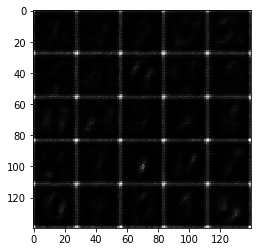

Epoch 1/2 - Batch 110/1875:  Discriminator Loss: 1.4490 Generator Loss: 0.6519
Epoch 1/2 - Batch 120/1875:  Discriminator Loss: 1.4755 Generator Loss: 0.4573
Epoch 1/2 - Batch 130/1875:  Discriminator Loss: 1.1990 Generator Loss: 0.6929
Epoch 1/2 - Batch 140/1875:  Discriminator Loss: 1.2047 Generator Loss: 0.8357
Epoch 1/2 - Batch 150/1875:  Discriminator Loss: 1.2620 Generator Loss: 0.7820
Epoch 1/2 - Batch 160/1875:  Discriminator Loss: 1.1549 Generator Loss: 0.9454
Epoch 1/2 - Batch 170/1875:  Discriminator Loss: 1.2328 Generator Loss: 0.6975
Epoch 1/2 - Batch 180/1875:  Discriminator Loss: 1.3457 Generator Loss: 0.6782
Epoch 1/2 - Batch 190/1875:  Discriminator Loss: 1.3353 Generator Loss: 0.5844
Epoch 1/2 - Batch 200/1875:  Discriminator Loss: 1.2050 Generator Loss: 0.7254


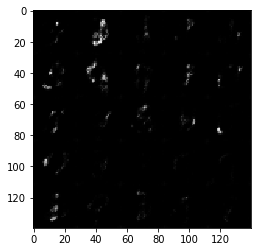

Epoch 1/2 - Batch 210/1875:  Discriminator Loss: 1.0845 Generator Loss: 0.9605
Epoch 1/2 - Batch 220/1875:  Discriminator Loss: 1.2070 Generator Loss: 1.0976
Epoch 1/2 - Batch 230/1875:  Discriminator Loss: 1.0861 Generator Loss: 1.0702
Epoch 1/2 - Batch 240/1875:  Discriminator Loss: 1.3547 Generator Loss: 0.5464
Epoch 1/2 - Batch 250/1875:  Discriminator Loss: 1.2724 Generator Loss: 0.7035
Epoch 1/2 - Batch 260/1875:  Discriminator Loss: 1.1182 Generator Loss: 0.9025
Epoch 1/2 - Batch 270/1875:  Discriminator Loss: 1.5001 Generator Loss: 2.6048
Epoch 1/2 - Batch 280/1875:  Discriminator Loss: 1.0946 Generator Loss: 0.8227
Epoch 1/2 - Batch 290/1875:  Discriminator Loss: 1.1266 Generator Loss: 1.3862
Epoch 1/2 - Batch 300/1875:  Discriminator Loss: 1.0842 Generator Loss: 0.7937


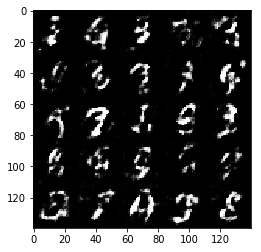

Epoch 1/2 - Batch 310/1875:  Discriminator Loss: 0.8947 Generator Loss: 1.1325
Epoch 1/2 - Batch 320/1875:  Discriminator Loss: 1.1311 Generator Loss: 1.7726
Epoch 1/2 - Batch 330/1875:  Discriminator Loss: 0.9194 Generator Loss: 1.0847
Epoch 1/2 - Batch 340/1875:  Discriminator Loss: 1.0480 Generator Loss: 0.8088
Epoch 1/2 - Batch 350/1875:  Discriminator Loss: 0.8806 Generator Loss: 1.5692
Epoch 1/2 - Batch 360/1875:  Discriminator Loss: 1.1279 Generator Loss: 0.7878
Epoch 1/2 - Batch 370/1875:  Discriminator Loss: 0.9988 Generator Loss: 1.3657
Epoch 1/2 - Batch 380/1875:  Discriminator Loss: 0.9603 Generator Loss: 1.1022
Epoch 1/2 - Batch 390/1875:  Discriminator Loss: 0.8708 Generator Loss: 1.4473
Epoch 1/2 - Batch 400/1875:  Discriminator Loss: 1.0339 Generator Loss: 0.9915


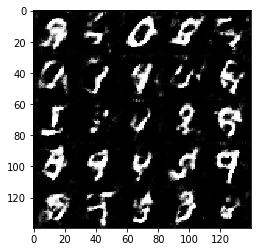

Epoch 1/2 - Batch 410/1875:  Discriminator Loss: 1.0508 Generator Loss: 0.8985
Epoch 1/2 - Batch 420/1875:  Discriminator Loss: 1.3634 Generator Loss: 0.5156
Epoch 1/2 - Batch 430/1875:  Discriminator Loss: 1.1598 Generator Loss: 1.0959
Epoch 1/2 - Batch 440/1875:  Discriminator Loss: 1.0848 Generator Loss: 1.4180
Epoch 1/2 - Batch 450/1875:  Discriminator Loss: 1.3078 Generator Loss: 0.5942
Epoch 1/2 - Batch 460/1875:  Discriminator Loss: 1.3321 Generator Loss: 2.3960
Epoch 1/2 - Batch 470/1875:  Discriminator Loss: 1.4487 Generator Loss: 0.5039
Epoch 1/2 - Batch 480/1875:  Discriminator Loss: 1.0282 Generator Loss: 1.0124
Epoch 1/2 - Batch 490/1875:  Discriminator Loss: 1.1032 Generator Loss: 0.9686
Epoch 1/2 - Batch 500/1875:  Discriminator Loss: 1.1230 Generator Loss: 0.8170


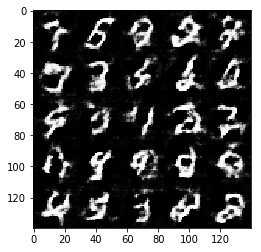

Epoch 1/2 - Batch 510/1875:  Discriminator Loss: 0.9574 Generator Loss: 1.7765
Epoch 1/2 - Batch 520/1875:  Discriminator Loss: 1.0782 Generator Loss: 0.8223
Epoch 1/2 - Batch 530/1875:  Discriminator Loss: 1.4054 Generator Loss: 0.5192
Epoch 1/2 - Batch 540/1875:  Discriminator Loss: 0.9417 Generator Loss: 1.5673
Epoch 1/2 - Batch 550/1875:  Discriminator Loss: 1.0590 Generator Loss: 1.1167
Epoch 1/2 - Batch 560/1875:  Discriminator Loss: 1.1258 Generator Loss: 1.9983
Epoch 1/2 - Batch 570/1875:  Discriminator Loss: 1.1591 Generator Loss: 0.7379
Epoch 1/2 - Batch 580/1875:  Discriminator Loss: 1.3965 Generator Loss: 0.5010
Epoch 1/2 - Batch 590/1875:  Discriminator Loss: 1.1168 Generator Loss: 0.7816
Epoch 1/2 - Batch 600/1875:  Discriminator Loss: 1.1765 Generator Loss: 1.2113


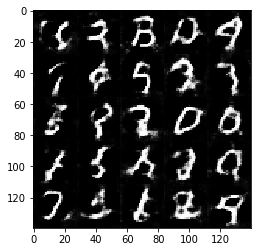

Epoch 1/2 - Batch 610/1875:  Discriminator Loss: 1.0791 Generator Loss: 1.4684
Epoch 1/2 - Batch 620/1875:  Discriminator Loss: 1.1357 Generator Loss: 0.7820
Epoch 1/2 - Batch 630/1875:  Discriminator Loss: 1.0172 Generator Loss: 1.4252
Epoch 1/2 - Batch 640/1875:  Discriminator Loss: 0.9370 Generator Loss: 1.0856
Epoch 1/2 - Batch 650/1875:  Discriminator Loss: 1.1849 Generator Loss: 0.8215
Epoch 1/2 - Batch 660/1875:  Discriminator Loss: 1.0457 Generator Loss: 1.2431
Epoch 1/2 - Batch 670/1875:  Discriminator Loss: 1.0759 Generator Loss: 0.8965
Epoch 1/2 - Batch 680/1875:  Discriminator Loss: 0.9924 Generator Loss: 1.3748
Epoch 1/2 - Batch 690/1875:  Discriminator Loss: 1.1281 Generator Loss: 0.8349
Epoch 1/2 - Batch 700/1875:  Discriminator Loss: 1.0253 Generator Loss: 0.9685


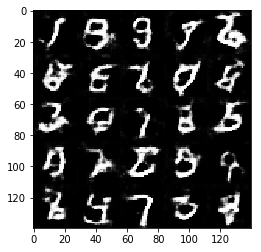

Epoch 1/2 - Batch 710/1875:  Discriminator Loss: 0.9692 Generator Loss: 1.1415
Epoch 1/2 - Batch 720/1875:  Discriminator Loss: 1.2011 Generator Loss: 0.7907
Epoch 1/2 - Batch 730/1875:  Discriminator Loss: 0.9888 Generator Loss: 1.1838
Epoch 1/2 - Batch 740/1875:  Discriminator Loss: 1.2270 Generator Loss: 1.4770
Epoch 1/2 - Batch 750/1875:  Discriminator Loss: 1.0408 Generator Loss: 0.8629
Epoch 1/2 - Batch 760/1875:  Discriminator Loss: 1.1952 Generator Loss: 0.7655
Epoch 1/2 - Batch 770/1875:  Discriminator Loss: 0.9793 Generator Loss: 1.4877
Epoch 1/2 - Batch 780/1875:  Discriminator Loss: 1.1998 Generator Loss: 0.6359
Epoch 1/2 - Batch 790/1875:  Discriminator Loss: 1.0880 Generator Loss: 1.2360
Epoch 1/2 - Batch 800/1875:  Discriminator Loss: 1.5436 Generator Loss: 2.1481


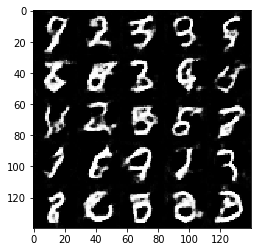

Epoch 1/2 - Batch 810/1875:  Discriminator Loss: 1.0725 Generator Loss: 1.2053
Epoch 1/2 - Batch 820/1875:  Discriminator Loss: 0.9819 Generator Loss: 0.9961
Epoch 1/2 - Batch 830/1875:  Discriminator Loss: 1.3073 Generator Loss: 0.6388
Epoch 1/2 - Batch 840/1875:  Discriminator Loss: 0.9499 Generator Loss: 1.1730
Epoch 1/2 - Batch 850/1875:  Discriminator Loss: 1.0396 Generator Loss: 0.9179
Epoch 1/2 - Batch 860/1875:  Discriminator Loss: 1.3507 Generator Loss: 0.6108
Epoch 1/2 - Batch 870/1875:  Discriminator Loss: 1.0689 Generator Loss: 0.8568
Epoch 1/2 - Batch 880/1875:  Discriminator Loss: 1.0501 Generator Loss: 1.1268
Epoch 1/2 - Batch 890/1875:  Discriminator Loss: 1.0052 Generator Loss: 1.0857
Epoch 1/2 - Batch 900/1875:  Discriminator Loss: 1.1278 Generator Loss: 0.8101


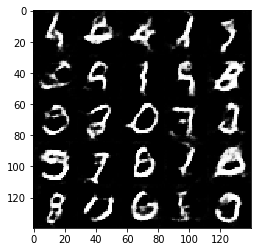

Epoch 1/2 - Batch 910/1875:  Discriminator Loss: 1.0580 Generator Loss: 1.3925
Epoch 1/2 - Batch 920/1875:  Discriminator Loss: 0.9803 Generator Loss: 1.3108
Epoch 1/2 - Batch 930/1875:  Discriminator Loss: 1.1370 Generator Loss: 0.8445
Epoch 1/2 - Batch 940/1875:  Discriminator Loss: 1.0624 Generator Loss: 1.3693
Epoch 1/2 - Batch 950/1875:  Discriminator Loss: 0.9962 Generator Loss: 1.1317
Epoch 1/2 - Batch 960/1875:  Discriminator Loss: 1.0997 Generator Loss: 0.9981
Epoch 1/2 - Batch 970/1875:  Discriminator Loss: 1.1692 Generator Loss: 1.0194
Epoch 1/2 - Batch 980/1875:  Discriminator Loss: 1.0905 Generator Loss: 0.9471
Epoch 1/2 - Batch 990/1875:  Discriminator Loss: 1.3504 Generator Loss: 0.5270
Epoch 1/2 - Batch 1000/1875:  Discriminator Loss: 1.2552 Generator Loss: 0.5950


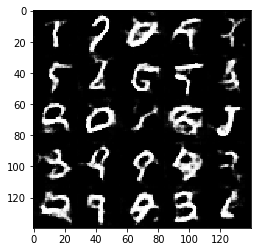

Epoch 1/2 - Batch 1010/1875:  Discriminator Loss: 1.0780 Generator Loss: 1.4188
Epoch 1/2 - Batch 1020/1875:  Discriminator Loss: 1.0557 Generator Loss: 1.4929
Epoch 1/2 - Batch 1030/1875:  Discriminator Loss: 0.9838 Generator Loss: 1.0818
Epoch 1/2 - Batch 1040/1875:  Discriminator Loss: 0.9657 Generator Loss: 1.0494
Epoch 1/2 - Batch 1050/1875:  Discriminator Loss: 0.9834 Generator Loss: 1.4926
Epoch 1/2 - Batch 1060/1875:  Discriminator Loss: 1.0752 Generator Loss: 1.1876
Epoch 1/2 - Batch 1070/1875:  Discriminator Loss: 1.0073 Generator Loss: 1.1383
Epoch 1/2 - Batch 1080/1875:  Discriminator Loss: 0.9357 Generator Loss: 1.2199
Epoch 1/2 - Batch 1090/1875:  Discriminator Loss: 1.1493 Generator Loss: 0.7619
Epoch 1/2 - Batch 1100/1875:  Discriminator Loss: 1.3027 Generator Loss: 0.5717


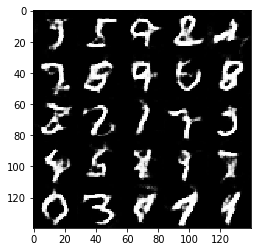

Epoch 1/2 - Batch 1110/1875:  Discriminator Loss: 1.0340 Generator Loss: 0.8411
Epoch 1/2 - Batch 1120/1875:  Discriminator Loss: 1.2067 Generator Loss: 0.8158
Epoch 1/2 - Batch 1130/1875:  Discriminator Loss: 1.0010 Generator Loss: 1.2602
Epoch 1/2 - Batch 1140/1875:  Discriminator Loss: 0.9691 Generator Loss: 1.3510
Epoch 1/2 - Batch 1150/1875:  Discriminator Loss: 0.9167 Generator Loss: 1.2081
Epoch 1/2 - Batch 1160/1875:  Discriminator Loss: 1.0927 Generator Loss: 0.8380
Epoch 1/2 - Batch 1170/1875:  Discriminator Loss: 0.9540 Generator Loss: 1.3609
Epoch 1/2 - Batch 1180/1875:  Discriminator Loss: 1.0132 Generator Loss: 1.2842
Epoch 1/2 - Batch 1190/1875:  Discriminator Loss: 1.0936 Generator Loss: 0.9746
Epoch 1/2 - Batch 1200/1875:  Discriminator Loss: 1.1016 Generator Loss: 0.8555


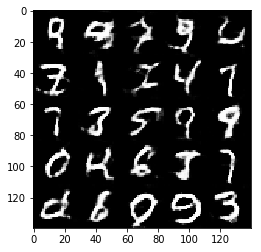

Epoch 1/2 - Batch 1210/1875:  Discriminator Loss: 0.9764 Generator Loss: 1.2608
Epoch 1/2 - Batch 1220/1875:  Discriminator Loss: 1.0685 Generator Loss: 0.9087
Epoch 1/2 - Batch 1230/1875:  Discriminator Loss: 1.0130 Generator Loss: 1.4155
Epoch 1/2 - Batch 1240/1875:  Discriminator Loss: 0.9715 Generator Loss: 1.7192
Epoch 1/2 - Batch 1250/1875:  Discriminator Loss: 1.0505 Generator Loss: 0.9123
Epoch 1/2 - Batch 1260/1875:  Discriminator Loss: 0.9872 Generator Loss: 0.9954
Epoch 1/2 - Batch 1270/1875:  Discriminator Loss: 1.2056 Generator Loss: 0.6970
Epoch 1/2 - Batch 1280/1875:  Discriminator Loss: 0.9620 Generator Loss: 1.2378
Epoch 1/2 - Batch 1290/1875:  Discriminator Loss: 1.3345 Generator Loss: 0.5949
Epoch 1/2 - Batch 1300/1875:  Discriminator Loss: 0.9646 Generator Loss: 1.8040


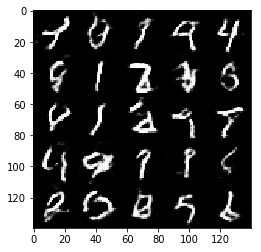

Epoch 1/2 - Batch 1310/1875:  Discriminator Loss: 1.0095 Generator Loss: 1.0066
Epoch 1/2 - Batch 1320/1875:  Discriminator Loss: 1.0165 Generator Loss: 0.9776
Epoch 1/2 - Batch 1330/1875:  Discriminator Loss: 0.9734 Generator Loss: 0.9334
Epoch 1/2 - Batch 1340/1875:  Discriminator Loss: 1.0106 Generator Loss: 1.2677
Epoch 1/2 - Batch 1350/1875:  Discriminator Loss: 1.0027 Generator Loss: 1.3912
Epoch 1/2 - Batch 1360/1875:  Discriminator Loss: 1.2594 Generator Loss: 0.6043
Epoch 1/2 - Batch 1370/1875:  Discriminator Loss: 1.0554 Generator Loss: 2.2397
Epoch 1/2 - Batch 1380/1875:  Discriminator Loss: 1.0623 Generator Loss: 2.5650
Epoch 1/2 - Batch 1390/1875:  Discriminator Loss: 1.0325 Generator Loss: 0.9403
Epoch 1/2 - Batch 1400/1875:  Discriminator Loss: 1.1037 Generator Loss: 0.8286


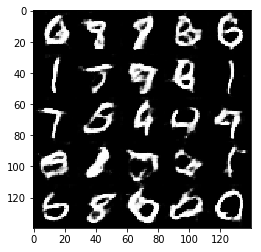

Epoch 1/2 - Batch 1410/1875:  Discriminator Loss: 1.2496 Generator Loss: 2.0403
Epoch 1/2 - Batch 1420/1875:  Discriminator Loss: 0.9089 Generator Loss: 1.3351
Epoch 1/2 - Batch 1430/1875:  Discriminator Loss: 0.9305 Generator Loss: 1.8127
Epoch 1/2 - Batch 1440/1875:  Discriminator Loss: 1.2223 Generator Loss: 0.7934
Epoch 1/2 - Batch 1450/1875:  Discriminator Loss: 1.0990 Generator Loss: 0.7840
Epoch 1/2 - Batch 1460/1875:  Discriminator Loss: 1.0148 Generator Loss: 0.9979
Epoch 1/2 - Batch 1470/1875:  Discriminator Loss: 0.9237 Generator Loss: 1.4500
Epoch 1/2 - Batch 1480/1875:  Discriminator Loss: 1.0552 Generator Loss: 1.0919
Epoch 1/2 - Batch 1490/1875:  Discriminator Loss: 1.0580 Generator Loss: 0.9032
Epoch 1/2 - Batch 1500/1875:  Discriminator Loss: 0.8860 Generator Loss: 1.2196


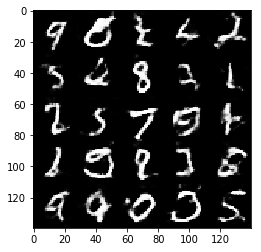

Epoch 1/2 - Batch 1510/1875:  Discriminator Loss: 0.9406 Generator Loss: 1.2952
Epoch 1/2 - Batch 1520/1875:  Discriminator Loss: 0.8358 Generator Loss: 1.5200
Epoch 1/2 - Batch 1530/1875:  Discriminator Loss: 0.8382 Generator Loss: 1.2688
Epoch 1/2 - Batch 1540/1875:  Discriminator Loss: 0.9477 Generator Loss: 1.1243
Epoch 1/2 - Batch 1550/1875:  Discriminator Loss: 0.8563 Generator Loss: 1.2907
Epoch 1/2 - Batch 1560/1875:  Discriminator Loss: 0.8054 Generator Loss: 1.6995
Epoch 1/2 - Batch 1570/1875:  Discriminator Loss: 1.0262 Generator Loss: 0.8652
Epoch 1/2 - Batch 1580/1875:  Discriminator Loss: 1.0635 Generator Loss: 1.2645
Epoch 1/2 - Batch 1590/1875:  Discriminator Loss: 0.9210 Generator Loss: 1.8519
Epoch 1/2 - Batch 1600/1875:  Discriminator Loss: 0.9368 Generator Loss: 1.0932


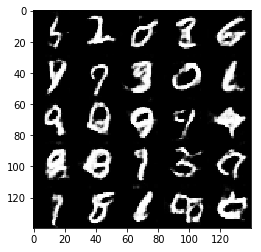

Epoch 1/2 - Batch 1610/1875:  Discriminator Loss: 1.1375 Generator Loss: 0.9114
Epoch 1/2 - Batch 1620/1875:  Discriminator Loss: 1.0617 Generator Loss: 1.8938
Epoch 1/2 - Batch 1630/1875:  Discriminator Loss: 0.8649 Generator Loss: 1.5298
Epoch 1/2 - Batch 1640/1875:  Discriminator Loss: 1.1721 Generator Loss: 0.7390
Epoch 1/2 - Batch 1650/1875:  Discriminator Loss: 1.1093 Generator Loss: 0.7784
Epoch 1/2 - Batch 1660/1875:  Discriminator Loss: 0.8272 Generator Loss: 1.3566
Epoch 1/2 - Batch 1670/1875:  Discriminator Loss: 1.1340 Generator Loss: 2.1946
Epoch 1/2 - Batch 1680/1875:  Discriminator Loss: 0.8836 Generator Loss: 1.5521
Epoch 1/2 - Batch 1690/1875:  Discriminator Loss: 0.8258 Generator Loss: 1.3632
Epoch 1/2 - Batch 1700/1875:  Discriminator Loss: 0.8538 Generator Loss: 1.1965


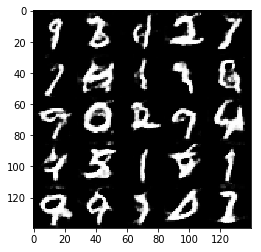

Epoch 1/2 - Batch 1710/1875:  Discriminator Loss: 1.0817 Generator Loss: 0.8571
Epoch 1/2 - Batch 1720/1875:  Discriminator Loss: 1.0229 Generator Loss: 1.1054
Epoch 1/2 - Batch 1730/1875:  Discriminator Loss: 0.8458 Generator Loss: 1.4654
Epoch 1/2 - Batch 1740/1875:  Discriminator Loss: 0.8302 Generator Loss: 1.5713
Epoch 1/2 - Batch 1750/1875:  Discriminator Loss: 0.9279 Generator Loss: 1.3789
Epoch 1/2 - Batch 1760/1875:  Discriminator Loss: 0.9967 Generator Loss: 0.9591
Epoch 1/2 - Batch 1770/1875:  Discriminator Loss: 0.7778 Generator Loss: 1.7138
Epoch 1/2 - Batch 1780/1875:  Discriminator Loss: 1.1392 Generator Loss: 1.9799
Epoch 1/2 - Batch 1790/1875:  Discriminator Loss: 1.2912 Generator Loss: 0.7732
Epoch 1/2 - Batch 1800/1875:  Discriminator Loss: 1.5444 Generator Loss: 0.4104


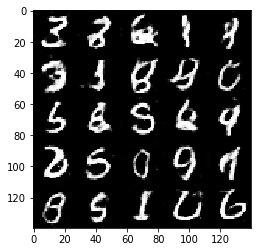

Epoch 1/2 - Batch 1810/1875:  Discriminator Loss: 0.8646 Generator Loss: 1.8923
Epoch 1/2 - Batch 1820/1875:  Discriminator Loss: 0.9766 Generator Loss: 0.9476
Epoch 1/2 - Batch 1830/1875:  Discriminator Loss: 0.9355 Generator Loss: 1.7857
Epoch 1/2 - Batch 1840/1875:  Discriminator Loss: 0.9185 Generator Loss: 1.1448
Epoch 1/2 - Batch 1850/1875:  Discriminator Loss: 0.8340 Generator Loss: 1.4847
Epoch 1/2 - Batch 1860/1875:  Discriminator Loss: 0.8548 Generator Loss: 1.1533
Epoch 1/2 - Batch 1870/1875:  Discriminator Loss: 1.0095 Generator Loss: 1.3896
Epoch 2/2 - Batch 10/1875:  Discriminator Loss: 0.9704 Generator Loss: 1.0855
Epoch 2/2 - Batch 20/1875:  Discriminator Loss: 0.8890 Generator Loss: 1.2246
Epoch 2/2 - Batch 30/1875:  Discriminator Loss: 1.1474 Generator Loss: 0.7642
Epoch 2/2 - Batch 40/1875:  Discriminator Loss: 1.0572 Generator Loss: 0.8938
Epoch 2/2 - Batch 50/1875:  Discriminator Loss: 0.9819 Generator Loss: 2.2323
Epoch 2/2 - Batch 60/1875:  Discriminator Loss: 0.

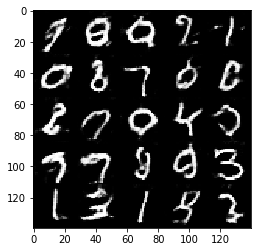

Epoch 2/2 - Batch 110/1875:  Discriminator Loss: 1.0103 Generator Loss: 1.1621
Epoch 2/2 - Batch 120/1875:  Discriminator Loss: 0.8496 Generator Loss: 1.3497
Epoch 2/2 - Batch 130/1875:  Discriminator Loss: 1.1137 Generator Loss: 0.8859
Epoch 2/2 - Batch 140/1875:  Discriminator Loss: 0.8950 Generator Loss: 1.2911
Epoch 2/2 - Batch 150/1875:  Discriminator Loss: 0.9889 Generator Loss: 0.9667
Epoch 2/2 - Batch 160/1875:  Discriminator Loss: 0.8115 Generator Loss: 1.2932
Epoch 2/2 - Batch 170/1875:  Discriminator Loss: 0.9995 Generator Loss: 1.5762
Epoch 2/2 - Batch 180/1875:  Discriminator Loss: 1.2518 Generator Loss: 2.5774
Epoch 2/2 - Batch 190/1875:  Discriminator Loss: 0.8914 Generator Loss: 1.3950
Epoch 2/2 - Batch 200/1875:  Discriminator Loss: 0.8901 Generator Loss: 1.2457


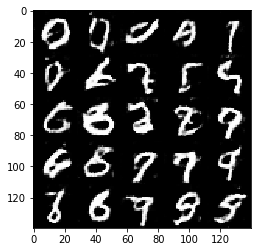

Epoch 2/2 - Batch 210/1875:  Discriminator Loss: 0.9958 Generator Loss: 1.5487
Epoch 2/2 - Batch 220/1875:  Discriminator Loss: 1.1520 Generator Loss: 2.2239
Epoch 2/2 - Batch 230/1875:  Discriminator Loss: 0.8552 Generator Loss: 1.3724
Epoch 2/2 - Batch 240/1875:  Discriminator Loss: 0.9608 Generator Loss: 1.0820
Epoch 2/2 - Batch 250/1875:  Discriminator Loss: 0.8345 Generator Loss: 1.4492
Epoch 2/2 - Batch 260/1875:  Discriminator Loss: 1.7909 Generator Loss: 0.3436
Epoch 2/2 - Batch 270/1875:  Discriminator Loss: 0.8859 Generator Loss: 1.3674
Epoch 2/2 - Batch 280/1875:  Discriminator Loss: 0.8459 Generator Loss: 1.2687
Epoch 2/2 - Batch 290/1875:  Discriminator Loss: 1.1291 Generator Loss: 0.8566
Epoch 2/2 - Batch 300/1875:  Discriminator Loss: 0.9563 Generator Loss: 0.9997


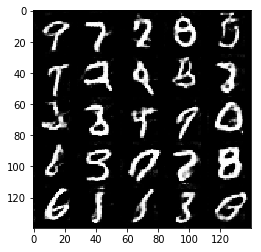

Epoch 2/2 - Batch 310/1875:  Discriminator Loss: 1.0727 Generator Loss: 0.9041
Epoch 2/2 - Batch 320/1875:  Discriminator Loss: 0.8700 Generator Loss: 1.2873
Epoch 2/2 - Batch 330/1875:  Discriminator Loss: 1.1737 Generator Loss: 0.7477
Epoch 2/2 - Batch 340/1875:  Discriminator Loss: 1.1471 Generator Loss: 0.8128
Epoch 2/2 - Batch 350/1875:  Discriminator Loss: 0.8366 Generator Loss: 1.8017
Epoch 2/2 - Batch 360/1875:  Discriminator Loss: 1.2348 Generator Loss: 0.6382
Epoch 2/2 - Batch 370/1875:  Discriminator Loss: 0.9463 Generator Loss: 1.4774
Epoch 2/2 - Batch 380/1875:  Discriminator Loss: 0.8466 Generator Loss: 1.3524
Epoch 2/2 - Batch 390/1875:  Discriminator Loss: 1.4219 Generator Loss: 0.5624
Epoch 2/2 - Batch 400/1875:  Discriminator Loss: 1.1299 Generator Loss: 0.7596


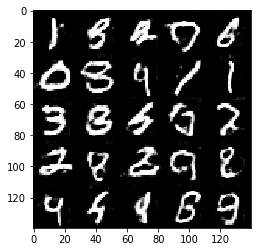

Epoch 2/2 - Batch 410/1875:  Discriminator Loss: 0.9600 Generator Loss: 1.0127
Epoch 2/2 - Batch 420/1875:  Discriminator Loss: 0.9934 Generator Loss: 0.9688
Epoch 2/2 - Batch 430/1875:  Discriminator Loss: 1.5481 Generator Loss: 0.4661
Epoch 2/2 - Batch 440/1875:  Discriminator Loss: 0.9621 Generator Loss: 1.0248
Epoch 2/2 - Batch 450/1875:  Discriminator Loss: 0.9879 Generator Loss: 1.0625
Epoch 2/2 - Batch 460/1875:  Discriminator Loss: 1.0377 Generator Loss: 1.1228
Epoch 2/2 - Batch 470/1875:  Discriminator Loss: 1.0635 Generator Loss: 0.9631
Epoch 2/2 - Batch 480/1875:  Discriminator Loss: 1.0207 Generator Loss: 0.9278
Epoch 2/2 - Batch 490/1875:  Discriminator Loss: 1.0232 Generator Loss: 1.9773
Epoch 2/2 - Batch 510/1875:  Discriminator Loss: 0.7417 Generator Loss: 1.7136
Epoch 2/2 - Batch 520/1875:  Discriminator Loss: 0.9464 Generator Loss: 1.3612
Epoch 2/2 - Batch 530/1875:  Discriminator Loss: 1.1315 Generator Loss: 0.8023
Epoch 2/2 - Batch 540/1875:  Discriminator Loss: 0.9

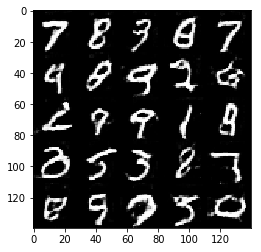

Epoch 2/2 - Batch 610/1875:  Discriminator Loss: 0.9386 Generator Loss: 1.4234
Epoch 2/2 - Batch 620/1875:  Discriminator Loss: 0.9112 Generator Loss: 1.1162
Epoch 2/2 - Batch 630/1875:  Discriminator Loss: 0.8546 Generator Loss: 1.2685
Epoch 2/2 - Batch 640/1875:  Discriminator Loss: 0.9749 Generator Loss: 1.1683
Epoch 2/2 - Batch 650/1875:  Discriminator Loss: 0.9320 Generator Loss: 1.4889
Epoch 2/2 - Batch 660/1875:  Discriminator Loss: 0.9908 Generator Loss: 1.0556
Epoch 2/2 - Batch 670/1875:  Discriminator Loss: 1.1112 Generator Loss: 0.8100
Epoch 2/2 - Batch 680/1875:  Discriminator Loss: 0.9874 Generator Loss: 1.4665
Epoch 2/2 - Batch 690/1875:  Discriminator Loss: 0.9632 Generator Loss: 1.3717
Epoch 2/2 - Batch 700/1875:  Discriminator Loss: 0.8498 Generator Loss: 1.7012


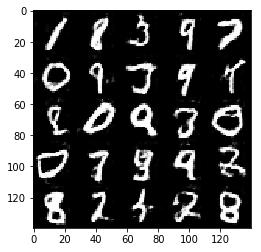

Epoch 2/2 - Batch 710/1875:  Discriminator Loss: 0.8298 Generator Loss: 1.2429
Epoch 2/2 - Batch 720/1875:  Discriminator Loss: 1.0842 Generator Loss: 0.7633
Epoch 2/2 - Batch 730/1875:  Discriminator Loss: 0.8534 Generator Loss: 1.4519
Epoch 2/2 - Batch 740/1875:  Discriminator Loss: 0.9612 Generator Loss: 1.2180
Epoch 2/2 - Batch 750/1875:  Discriminator Loss: 0.8722 Generator Loss: 1.7935
Epoch 2/2 - Batch 760/1875:  Discriminator Loss: 1.1504 Generator Loss: 0.8770
Epoch 2/2 - Batch 770/1875:  Discriminator Loss: 0.9347 Generator Loss: 1.8544
Epoch 2/2 - Batch 780/1875:  Discriminator Loss: 1.2272 Generator Loss: 0.6920
Epoch 2/2 - Batch 790/1875:  Discriminator Loss: 0.8282 Generator Loss: 1.4471
Epoch 2/2 - Batch 800/1875:  Discriminator Loss: 1.1182 Generator Loss: 2.1608


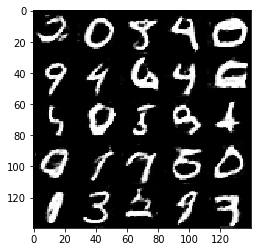

Epoch 2/2 - Batch 810/1875:  Discriminator Loss: 0.9105 Generator Loss: 1.0656
Epoch 2/2 - Batch 820/1875:  Discriminator Loss: 0.7358 Generator Loss: 1.6922
Epoch 2/2 - Batch 830/1875:  Discriminator Loss: 0.8809 Generator Loss: 1.3554
Epoch 2/2 - Batch 840/1875:  Discriminator Loss: 1.1354 Generator Loss: 0.8894
Epoch 2/2 - Batch 850/1875:  Discriminator Loss: 0.8582 Generator Loss: 1.6421
Epoch 2/2 - Batch 860/1875:  Discriminator Loss: 1.1031 Generator Loss: 0.9299
Epoch 2/2 - Batch 870/1875:  Discriminator Loss: 0.8749 Generator Loss: 1.7227
Epoch 2/2 - Batch 880/1875:  Discriminator Loss: 0.9330 Generator Loss: 1.2117
Epoch 2/2 - Batch 890/1875:  Discriminator Loss: 0.9066 Generator Loss: 1.5619
Epoch 2/2 - Batch 900/1875:  Discriminator Loss: 0.8742 Generator Loss: 1.4570


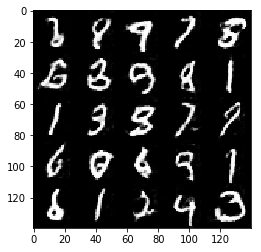

Epoch 2/2 - Batch 910/1875:  Discriminator Loss: 0.9007 Generator Loss: 1.2459
Epoch 2/2 - Batch 920/1875:  Discriminator Loss: 0.9837 Generator Loss: 0.9665
Epoch 2/2 - Batch 930/1875:  Discriminator Loss: 0.9041 Generator Loss: 2.4509
Epoch 2/2 - Batch 940/1875:  Discriminator Loss: 0.8752 Generator Loss: 1.4811
Epoch 2/2 - Batch 950/1875:  Discriminator Loss: 1.0174 Generator Loss: 0.9856
Epoch 2/2 - Batch 960/1875:  Discriminator Loss: 0.9099 Generator Loss: 1.5713
Epoch 2/2 - Batch 970/1875:  Discriminator Loss: 1.0348 Generator Loss: 1.3915
Epoch 2/2 - Batch 980/1875:  Discriminator Loss: 1.0062 Generator Loss: 1.0307
Epoch 2/2 - Batch 990/1875:  Discriminator Loss: 1.0851 Generator Loss: 0.8207
Epoch 2/2 - Batch 1000/1875:  Discriminator Loss: 1.0357 Generator Loss: 0.8609


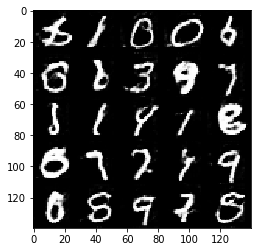

Epoch 2/2 - Batch 1010/1875:  Discriminator Loss: 0.9199 Generator Loss: 1.3333
Epoch 2/2 - Batch 1020/1875:  Discriminator Loss: 0.8716 Generator Loss: 1.2666
Epoch 2/2 - Batch 1030/1875:  Discriminator Loss: 0.8973 Generator Loss: 1.2389
Epoch 2/2 - Batch 1040/1875:  Discriminator Loss: 0.8288 Generator Loss: 1.5036
Epoch 2/2 - Batch 1050/1875:  Discriminator Loss: 1.0120 Generator Loss: 1.0930
Epoch 2/2 - Batch 1060/1875:  Discriminator Loss: 0.9919 Generator Loss: 1.7039
Epoch 2/2 - Batch 1070/1875:  Discriminator Loss: 0.9439 Generator Loss: 1.1305
Epoch 2/2 - Batch 1080/1875:  Discriminator Loss: 1.3359 Generator Loss: 0.5847
Epoch 2/2 - Batch 1090/1875:  Discriminator Loss: 0.9380 Generator Loss: 1.3749
Epoch 2/2 - Batch 1100/1875:  Discriminator Loss: 1.2126 Generator Loss: 0.7460


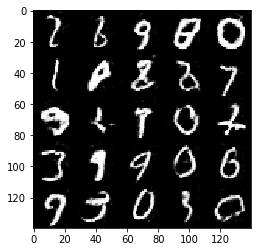

Epoch 2/2 - Batch 1110/1875:  Discriminator Loss: 0.9438 Generator Loss: 1.1774
Epoch 2/2 - Batch 1120/1875:  Discriminator Loss: 0.9889 Generator Loss: 1.0350
Epoch 2/2 - Batch 1130/1875:  Discriminator Loss: 0.9300 Generator Loss: 1.0799
Epoch 2/2 - Batch 1140/1875:  Discriminator Loss: 0.9083 Generator Loss: 1.4689
Epoch 2/2 - Batch 1150/1875:  Discriminator Loss: 0.7969 Generator Loss: 1.7763
Epoch 2/2 - Batch 1160/1875:  Discriminator Loss: 1.4011 Generator Loss: 0.6628
Epoch 2/2 - Batch 1170/1875:  Discriminator Loss: 1.8026 Generator Loss: 3.9117
Epoch 2/2 - Batch 1180/1875:  Discriminator Loss: 1.0012 Generator Loss: 1.4836
Epoch 2/2 - Batch 1190/1875:  Discriminator Loss: 0.9540 Generator Loss: 1.4132
Epoch 2/2 - Batch 1200/1875:  Discriminator Loss: 0.8811 Generator Loss: 1.2776


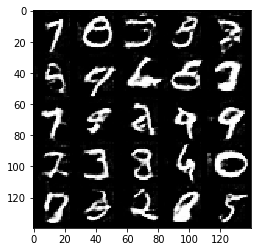

Epoch 2/2 - Batch 1210/1875:  Discriminator Loss: 0.9335 Generator Loss: 1.2670
Epoch 2/2 - Batch 1220/1875:  Discriminator Loss: 1.0386 Generator Loss: 0.8621
Epoch 2/2 - Batch 1230/1875:  Discriminator Loss: 0.9941 Generator Loss: 1.2014
Epoch 2/2 - Batch 1240/1875:  Discriminator Loss: 0.8008 Generator Loss: 1.8459
Epoch 2/2 - Batch 1250/1875:  Discriminator Loss: 0.7775 Generator Loss: 1.5242
Epoch 2/2 - Batch 1260/1875:  Discriminator Loss: 0.8864 Generator Loss: 1.6253
Epoch 2/2 - Batch 1270/1875:  Discriminator Loss: 0.8133 Generator Loss: 1.5767
Epoch 2/2 - Batch 1280/1875:  Discriminator Loss: 0.8522 Generator Loss: 1.8174
Epoch 2/2 - Batch 1290/1875:  Discriminator Loss: 1.0027 Generator Loss: 0.9379
Epoch 2/2 - Batch 1300/1875:  Discriminator Loss: 0.8196 Generator Loss: 1.2950


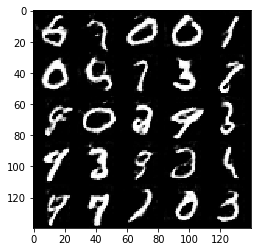

Epoch 2/2 - Batch 1310/1875:  Discriminator Loss: 2.1731 Generator Loss: 0.3295
Epoch 2/2 - Batch 1320/1875:  Discriminator Loss: 1.0941 Generator Loss: 1.2295
Epoch 2/2 - Batch 1330/1875:  Discriminator Loss: 0.9030 Generator Loss: 1.2367
Epoch 2/2 - Batch 1340/1875:  Discriminator Loss: 0.9879 Generator Loss: 1.2384
Epoch 2/2 - Batch 1350/1875:  Discriminator Loss: 1.0711 Generator Loss: 0.8821
Epoch 2/2 - Batch 1360/1875:  Discriminator Loss: 0.9528 Generator Loss: 1.0979
Epoch 2/2 - Batch 1370/1875:  Discriminator Loss: 0.9442 Generator Loss: 1.3589
Epoch 2/2 - Batch 1380/1875:  Discriminator Loss: 0.9475 Generator Loss: 1.1281
Epoch 2/2 - Batch 1390/1875:  Discriminator Loss: 0.8495 Generator Loss: 1.2823
Epoch 2/2 - Batch 1400/1875:  Discriminator Loss: 0.9207 Generator Loss: 1.4767


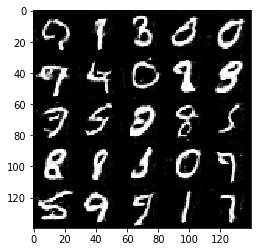

Epoch 2/2 - Batch 1410/1875:  Discriminator Loss: 0.9478 Generator Loss: 1.6753
Epoch 2/2 - Batch 1420/1875:  Discriminator Loss: 0.9429 Generator Loss: 1.5520
Epoch 2/2 - Batch 1430/1875:  Discriminator Loss: 0.8578 Generator Loss: 1.4601
Epoch 2/2 - Batch 1440/1875:  Discriminator Loss: 1.3859 Generator Loss: 0.7092
Epoch 2/2 - Batch 1450/1875:  Discriminator Loss: 1.0576 Generator Loss: 0.9055
Epoch 2/2 - Batch 1460/1875:  Discriminator Loss: 1.0802 Generator Loss: 1.0309
Epoch 2/2 - Batch 1470/1875:  Discriminator Loss: 0.8049 Generator Loss: 1.7017
Epoch 2/2 - Batch 1480/1875:  Discriminator Loss: 0.9814 Generator Loss: 1.0285
Epoch 2/2 - Batch 1490/1875:  Discriminator Loss: 0.8701 Generator Loss: 1.4977
Epoch 2/2 - Batch 1500/1875:  Discriminator Loss: 1.2115 Generator Loss: 0.7595


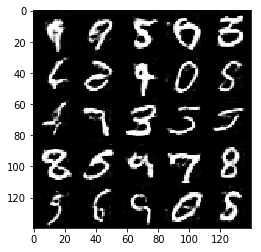

Epoch 2/2 - Batch 1510/1875:  Discriminator Loss: 1.2401 Generator Loss: 0.7911
Epoch 2/2 - Batch 1520/1875:  Discriminator Loss: 0.9285 Generator Loss: 1.1737
Epoch 2/2 - Batch 1530/1875:  Discriminator Loss: 0.9051 Generator Loss: 1.2436
Epoch 2/2 - Batch 1540/1875:  Discriminator Loss: 0.9008 Generator Loss: 1.7554
Epoch 2/2 - Batch 1550/1875:  Discriminator Loss: 0.9736 Generator Loss: 2.0946
Epoch 2/2 - Batch 1560/1875:  Discriminator Loss: 0.7902 Generator Loss: 1.7248
Epoch 2/2 - Batch 1570/1875:  Discriminator Loss: 0.9854 Generator Loss: 2.0758
Epoch 2/2 - Batch 1580/1875:  Discriminator Loss: 1.4086 Generator Loss: 0.5294
Epoch 2/2 - Batch 1590/1875:  Discriminator Loss: 1.0775 Generator Loss: 0.9619
Epoch 2/2 - Batch 1600/1875:  Discriminator Loss: 0.8715 Generator Loss: 1.3632


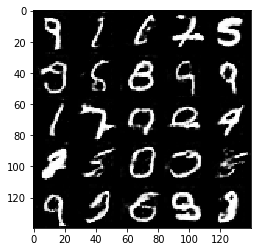

Epoch 2/2 - Batch 1610/1875:  Discriminator Loss: 1.0458 Generator Loss: 0.9753
Epoch 2/2 - Batch 1620/1875:  Discriminator Loss: 0.9847 Generator Loss: 1.2647
Epoch 2/2 - Batch 1630/1875:  Discriminator Loss: 0.8268 Generator Loss: 1.5530
Epoch 2/2 - Batch 1640/1875:  Discriminator Loss: 0.9587 Generator Loss: 1.1813
Epoch 2/2 - Batch 1650/1875:  Discriminator Loss: 0.9844 Generator Loss: 1.1351
Epoch 2/2 - Batch 1660/1875:  Discriminator Loss: 0.8421 Generator Loss: 1.4574
Epoch 2/2 - Batch 1670/1875:  Discriminator Loss: 0.9258 Generator Loss: 1.6755
Epoch 2/2 - Batch 1680/1875:  Discriminator Loss: 0.9695 Generator Loss: 1.6844
Epoch 2/2 - Batch 1690/1875:  Discriminator Loss: 0.9163 Generator Loss: 1.4379
Epoch 2/2 - Batch 1700/1875:  Discriminator Loss: 1.1287 Generator Loss: 0.8058


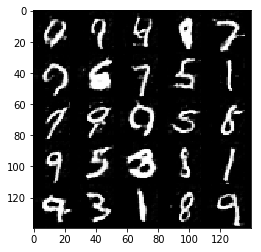

Epoch 2/2 - Batch 1710/1875:  Discriminator Loss: 0.8689 Generator Loss: 1.5526
Epoch 2/2 - Batch 1720/1875:  Discriminator Loss: 1.0794 Generator Loss: 0.9505
Epoch 2/2 - Batch 1730/1875:  Discriminator Loss: 0.8488 Generator Loss: 1.4646
Epoch 2/2 - Batch 1740/1875:  Discriminator Loss: 0.9050 Generator Loss: 1.7450
Epoch 2/2 - Batch 1750/1875:  Discriminator Loss: 0.9368 Generator Loss: 1.2660
Epoch 2/2 - Batch 1760/1875:  Discriminator Loss: 0.8016 Generator Loss: 1.7366
Epoch 2/2 - Batch 1770/1875:  Discriminator Loss: 0.9267 Generator Loss: 1.1445
Epoch 2/2 - Batch 1780/1875:  Discriminator Loss: 1.0970 Generator Loss: 1.0656
Epoch 2/2 - Batch 1790/1875:  Discriminator Loss: 1.0096 Generator Loss: 2.3293
Epoch 2/2 - Batch 1800/1875:  Discriminator Loss: 0.8211 Generator Loss: 1.5140


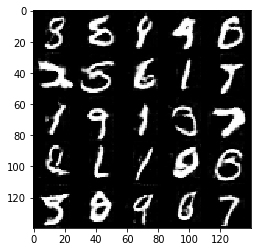

Epoch 2/2 - Batch 1810/1875:  Discriminator Loss: 0.9129 Generator Loss: 1.3316
Epoch 2/2 - Batch 1820/1875:  Discriminator Loss: 0.7930 Generator Loss: 1.2865
Epoch 2/2 - Batch 1830/1875:  Discriminator Loss: 0.7804 Generator Loss: 1.6670
Epoch 2/2 - Batch 1840/1875:  Discriminator Loss: 0.9325 Generator Loss: 1.1438
Epoch 2/2 - Batch 1850/1875:  Discriminator Loss: 0.8478 Generator Loss: 1.2011
Epoch 2/2 - Batch 1860/1875:  Discriminator Loss: 0.8258 Generator Loss: 1.2405
Epoch 2/2 - Batch 1870/1875:  Discriminator Loss: 1.0484 Generator Loss: 1.4791


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Here we can run the GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 - Batch 10/6331:  Discriminator Loss: 0.6167 Generator Loss: 1.8300
Epoch 1/1 - Batch 20/6331:  Discriminator Loss: 0.5558 Generator Loss: 3.0592
Epoch 1/1 - Batch 30/6331:  Discriminator Loss: 0.5004 Generator Loss: 5.1110
Epoch 1/1 - Batch 40/6331:  Discriminator Loss: 0.4804 Generator Loss: 2.8130
Epoch 1/1 - Batch 50/6331:  Discriminator Loss: 0.5904 Generator Loss: 2.9355
Epoch 1/1 - Batch 60/6331:  Discriminator Loss: 1.2252 Generator Loss: 0.7539
Epoch 1/1 - Batch 70/6331:  Discriminator Loss: 1.0138 Generator Loss: 0.8833
Epoch 1/1 - Batch 80/6331:  Discriminator Loss: 0.9490 Generator Loss: 0.9487
Epoch 1/1 - Batch 90/6331:  Discriminator Loss: 0.6084 Generator Loss: 1.9677
Epoch 1/1 - Batch 100/6331:  Discriminator Loss: 0.8307 Generator Loss: 1.1697


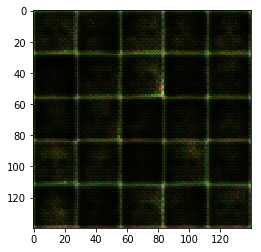

Epoch 1/1 - Batch 110/6331:  Discriminator Loss: 0.5974 Generator Loss: 1.8250
Epoch 1/1 - Batch 120/6331:  Discriminator Loss: 0.8098 Generator Loss: 1.2284
Epoch 1/1 - Batch 130/6331:  Discriminator Loss: 1.4455 Generator Loss: 0.5009
Epoch 1/1 - Batch 140/6331:  Discriminator Loss: 0.9865 Generator Loss: 1.0100
Epoch 1/1 - Batch 150/6331:  Discriminator Loss: 0.7544 Generator Loss: 2.2835
Epoch 1/1 - Batch 160/6331:  Discriminator Loss: 1.6610 Generator Loss: 0.3775
Epoch 1/1 - Batch 170/6331:  Discriminator Loss: 0.7476 Generator Loss: 2.1418
Epoch 1/1 - Batch 180/6331:  Discriminator Loss: 0.6521 Generator Loss: 2.2403
Epoch 1/1 - Batch 190/6331:  Discriminator Loss: 0.5491 Generator Loss: 2.2678
Epoch 1/1 - Batch 200/6331:  Discriminator Loss: 0.9220 Generator Loss: 1.0897


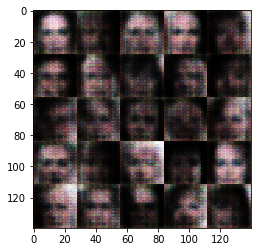

Epoch 1/1 - Batch 210/6331:  Discriminator Loss: 0.5267 Generator Loss: 2.2656
Epoch 1/1 - Batch 220/6331:  Discriminator Loss: 0.9467 Generator Loss: 3.3005
Epoch 1/1 - Batch 230/6331:  Discriminator Loss: 0.8281 Generator Loss: 1.2961
Epoch 1/1 - Batch 240/6331:  Discriminator Loss: 1.5249 Generator Loss: 0.4712
Epoch 1/1 - Batch 250/6331:  Discriminator Loss: 0.7523 Generator Loss: 1.8394
Epoch 1/1 - Batch 260/6331:  Discriminator Loss: 0.6507 Generator Loss: 1.4852
Epoch 1/1 - Batch 270/6331:  Discriminator Loss: 1.0941 Generator Loss: 2.1624
Epoch 1/1 - Batch 280/6331:  Discriminator Loss: 2.0773 Generator Loss: 0.2849
Epoch 1/1 - Batch 290/6331:  Discriminator Loss: 0.9831 Generator Loss: 1.3455
Epoch 1/1 - Batch 300/6331:  Discriminator Loss: 1.1181 Generator Loss: 1.1734


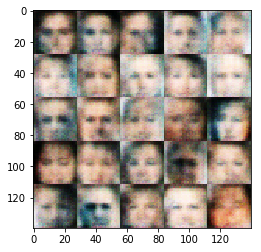

Epoch 1/1 - Batch 310/6331:  Discriminator Loss: 0.8370 Generator Loss: 1.3136
Epoch 1/1 - Batch 320/6331:  Discriminator Loss: 0.5075 Generator Loss: 2.5595
Epoch 1/1 - Batch 330/6331:  Discriminator Loss: 0.8461 Generator Loss: 1.0937
Epoch 1/1 - Batch 340/6331:  Discriminator Loss: 0.8022 Generator Loss: 3.1978
Epoch 1/1 - Batch 350/6331:  Discriminator Loss: 1.0086 Generator Loss: 0.9921
Epoch 1/1 - Batch 360/6331:  Discriminator Loss: 0.8094 Generator Loss: 1.7174
Epoch 1/1 - Batch 370/6331:  Discriminator Loss: 0.5077 Generator Loss: 2.6283
Epoch 1/1 - Batch 380/6331:  Discriminator Loss: 0.5088 Generator Loss: 2.4858
Epoch 1/1 - Batch 390/6331:  Discriminator Loss: 0.5581 Generator Loss: 5.1658
Epoch 1/1 - Batch 400/6331:  Discriminator Loss: 0.6964 Generator Loss: 5.1528


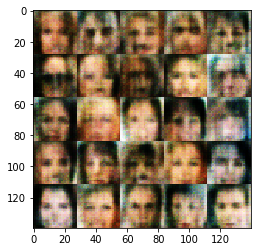

Epoch 1/1 - Batch 410/6331:  Discriminator Loss: 0.6391 Generator Loss: 1.7915
Epoch 1/1 - Batch 420/6331:  Discriminator Loss: 0.5813 Generator Loss: 1.8419
Epoch 1/1 - Batch 430/6331:  Discriminator Loss: 0.5024 Generator Loss: 2.6332
Epoch 1/1 - Batch 440/6331:  Discriminator Loss: 0.6240 Generator Loss: 1.7534
Epoch 1/1 - Batch 450/6331:  Discriminator Loss: 0.4397 Generator Loss: 4.0615
Epoch 1/1 - Batch 460/6331:  Discriminator Loss: 2.2727 Generator Loss: 4.4430
Epoch 1/1 - Batch 470/6331:  Discriminator Loss: 1.0674 Generator Loss: 1.0815
Epoch 1/1 - Batch 480/6331:  Discriminator Loss: 0.7823 Generator Loss: 2.1284
Epoch 1/1 - Batch 490/6331:  Discriminator Loss: 0.4693 Generator Loss: 3.1954
Epoch 1/1 - Batch 500/6331:  Discriminator Loss: 0.4416 Generator Loss: 4.4157


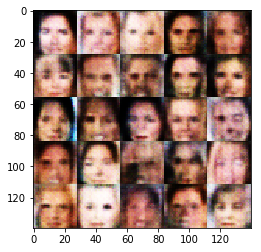

Epoch 1/1 - Batch 510/6331:  Discriminator Loss: 1.3369 Generator Loss: 0.6398
Epoch 1/1 - Batch 520/6331:  Discriminator Loss: 0.4344 Generator Loss: 5.1013
Epoch 1/1 - Batch 530/6331:  Discriminator Loss: 0.5256 Generator Loss: 2.7945
Epoch 1/1 - Batch 540/6331:  Discriminator Loss: 1.1467 Generator Loss: 0.6790
Epoch 1/1 - Batch 550/6331:  Discriminator Loss: 0.5654 Generator Loss: 3.5030
Epoch 1/1 - Batch 560/6331:  Discriminator Loss: 0.4490 Generator Loss: 4.5476
Epoch 1/1 - Batch 570/6331:  Discriminator Loss: 0.5983 Generator Loss: 2.3125
Epoch 1/1 - Batch 580/6331:  Discriminator Loss: 0.4324 Generator Loss: 8.1276
Epoch 1/1 - Batch 590/6331:  Discriminator Loss: 0.4501 Generator Loss: 4.2333
Epoch 1/1 - Batch 600/6331:  Discriminator Loss: 0.5161 Generator Loss: 3.5323


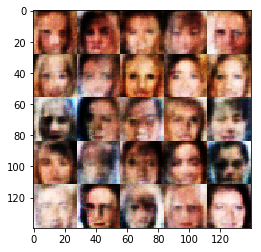

Epoch 1/1 - Batch 610/6331:  Discriminator Loss: 0.7027 Generator Loss: 5.8735
Epoch 1/1 - Batch 620/6331:  Discriminator Loss: 0.6322 Generator Loss: 1.6868
Epoch 1/1 - Batch 630/6331:  Discriminator Loss: 0.4527 Generator Loss: 3.3745
Epoch 1/1 - Batch 640/6331:  Discriminator Loss: 0.5345 Generator Loss: 3.4100
Epoch 1/1 - Batch 650/6331:  Discriminator Loss: 0.5475 Generator Loss: 2.0639
Epoch 1/1 - Batch 660/6331:  Discriminator Loss: 0.5260 Generator Loss: 2.1633
Epoch 1/1 - Batch 670/6331:  Discriminator Loss: 0.4850 Generator Loss: 2.5831
Epoch 1/1 - Batch 680/6331:  Discriminator Loss: 0.6381 Generator Loss: 1.7598
Epoch 1/1 - Batch 690/6331:  Discriminator Loss: 0.9482 Generator Loss: 1.0026
Epoch 1/1 - Batch 700/6331:  Discriminator Loss: 0.6426 Generator Loss: 1.6547


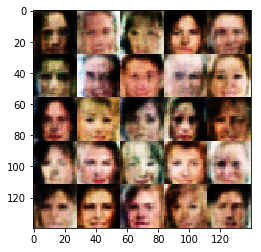

Epoch 1/1 - Batch 710/6331:  Discriminator Loss: 0.6278 Generator Loss: 2.2448
Epoch 1/1 - Batch 720/6331:  Discriminator Loss: 0.4108 Generator Loss: 3.0667
Epoch 1/1 - Batch 730/6331:  Discriminator Loss: 0.5182 Generator Loss: 3.7572
Epoch 1/1 - Batch 740/6331:  Discriminator Loss: 0.4631 Generator Loss: 2.7323
Epoch 1/1 - Batch 750/6331:  Discriminator Loss: 0.5682 Generator Loss: 3.2804
Epoch 1/1 - Batch 760/6331:  Discriminator Loss: 0.9226 Generator Loss: 4.1334
Epoch 1/1 - Batch 770/6331:  Discriminator Loss: 0.6192 Generator Loss: 5.5414
Epoch 1/1 - Batch 780/6331:  Discriminator Loss: 0.6783 Generator Loss: 1.9083
Epoch 1/1 - Batch 790/6331:  Discriminator Loss: 0.7636 Generator Loss: 1.4314
Epoch 1/1 - Batch 800/6331:  Discriminator Loss: 0.8988 Generator Loss: 2.9622


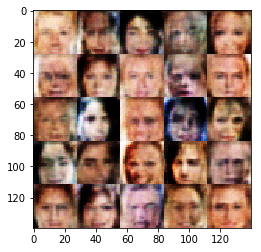

Epoch 1/1 - Batch 810/6331:  Discriminator Loss: 0.5807 Generator Loss: 3.2138
Epoch 1/1 - Batch 820/6331:  Discriminator Loss: 0.3944 Generator Loss: 4.2743
Epoch 1/1 - Batch 830/6331:  Discriminator Loss: 1.0527 Generator Loss: 0.9318
Epoch 1/1 - Batch 840/6331:  Discriminator Loss: 0.6378 Generator Loss: 4.0971
Epoch 1/1 - Batch 850/6331:  Discriminator Loss: 0.8337 Generator Loss: 1.9791
Epoch 1/1 - Batch 860/6331:  Discriminator Loss: 0.5069 Generator Loss: 2.9370
Epoch 1/1 - Batch 870/6331:  Discriminator Loss: 1.2319 Generator Loss: 3.5128
Epoch 1/1 - Batch 880/6331:  Discriminator Loss: 0.6100 Generator Loss: 2.5647
Epoch 1/1 - Batch 890/6331:  Discriminator Loss: 0.9507 Generator Loss: 1.0611
Epoch 1/1 - Batch 900/6331:  Discriminator Loss: 0.7945 Generator Loss: 2.3620


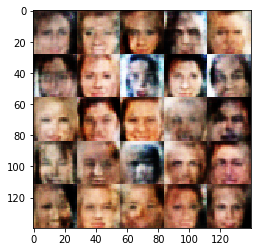

Epoch 1/1 - Batch 910/6331:  Discriminator Loss: 0.6964 Generator Loss: 2.1068
Epoch 1/1 - Batch 920/6331:  Discriminator Loss: 0.4997 Generator Loss: 3.4277
Epoch 1/1 - Batch 930/6331:  Discriminator Loss: 0.8066 Generator Loss: 1.2768
Epoch 1/1 - Batch 940/6331:  Discriminator Loss: 0.4655 Generator Loss: 3.9210
Epoch 1/1 - Batch 950/6331:  Discriminator Loss: 0.5242 Generator Loss: 2.5126
Epoch 1/1 - Batch 960/6331:  Discriminator Loss: 0.4670 Generator Loss: 3.5708
Epoch 1/1 - Batch 970/6331:  Discriminator Loss: 0.5038 Generator Loss: 4.2228
Epoch 1/1 - Batch 980/6331:  Discriminator Loss: 0.8690 Generator Loss: 1.5335
Epoch 1/1 - Batch 990/6331:  Discriminator Loss: 0.7725 Generator Loss: 1.3557
Epoch 1/1 - Batch 1000/6331:  Discriminator Loss: 0.5831 Generator Loss: 2.1075


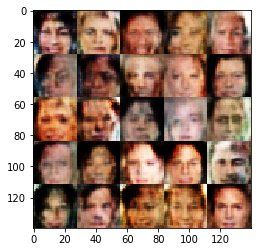

Epoch 1/1 - Batch 1010/6331:  Discriminator Loss: 0.7218 Generator Loss: 1.7052
Epoch 1/1 - Batch 1020/6331:  Discriminator Loss: 0.6885 Generator Loss: 2.0744
Epoch 1/1 - Batch 1030/6331:  Discriminator Loss: 0.6591 Generator Loss: 1.6169
Epoch 1/1 - Batch 1040/6331:  Discriminator Loss: 0.4155 Generator Loss: 4.4381
Epoch 1/1 - Batch 1050/6331:  Discriminator Loss: 0.4851 Generator Loss: 3.4855
Epoch 1/1 - Batch 1060/6331:  Discriminator Loss: 0.5291 Generator Loss: 3.3181
Epoch 1/1 - Batch 1070/6331:  Discriminator Loss: 0.7952 Generator Loss: 1.6587
Epoch 1/1 - Batch 1080/6331:  Discriminator Loss: 0.9434 Generator Loss: 2.4955
Epoch 1/1 - Batch 1090/6331:  Discriminator Loss: 1.1610 Generator Loss: 0.9025
Epoch 1/1 - Batch 1100/6331:  Discriminator Loss: 0.9463 Generator Loss: 0.9365


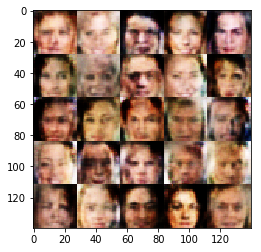

Epoch 1/1 - Batch 1110/6331:  Discriminator Loss: 1.0246 Generator Loss: 0.9629
Epoch 1/1 - Batch 1120/6331:  Discriminator Loss: 0.5376 Generator Loss: 2.7185
Epoch 1/1 - Batch 1130/6331:  Discriminator Loss: 0.8937 Generator Loss: 1.1505
Epoch 1/1 - Batch 1140/6331:  Discriminator Loss: 0.8072 Generator Loss: 2.6344
Epoch 1/1 - Batch 1150/6331:  Discriminator Loss: 0.6779 Generator Loss: 1.7831
Epoch 1/1 - Batch 1160/6331:  Discriminator Loss: 0.7815 Generator Loss: 1.9200
Epoch 1/1 - Batch 1170/6331:  Discriminator Loss: 0.7013 Generator Loss: 1.6968
Epoch 1/1 - Batch 1180/6331:  Discriminator Loss: 0.8823 Generator Loss: 1.0444
Epoch 1/1 - Batch 1190/6331:  Discriminator Loss: 0.5658 Generator Loss: 2.2397
Epoch 1/1 - Batch 1200/6331:  Discriminator Loss: 0.6695 Generator Loss: 1.8122


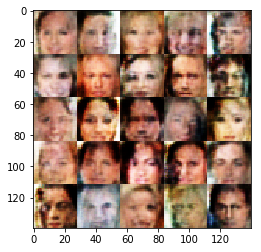

Epoch 1/1 - Batch 1210/6331:  Discriminator Loss: 0.8883 Generator Loss: 1.1619
Epoch 1/1 - Batch 1220/6331:  Discriminator Loss: 0.8612 Generator Loss: 1.2491
Epoch 1/1 - Batch 1230/6331:  Discriminator Loss: 0.5188 Generator Loss: 3.3757
Epoch 1/1 - Batch 1240/6331:  Discriminator Loss: 0.8335 Generator Loss: 2.4151
Epoch 1/1 - Batch 1250/6331:  Discriminator Loss: 0.8597 Generator Loss: 1.3347
Epoch 1/1 - Batch 1260/6331:  Discriminator Loss: 0.5931 Generator Loss: 2.8467
Epoch 1/1 - Batch 1270/6331:  Discriminator Loss: 0.4702 Generator Loss: 3.0160
Epoch 1/1 - Batch 1280/6331:  Discriminator Loss: 0.8641 Generator Loss: 1.9960
Epoch 1/1 - Batch 1290/6331:  Discriminator Loss: 0.8575 Generator Loss: 1.3036
Epoch 1/1 - Batch 1300/6331:  Discriminator Loss: 1.2415 Generator Loss: 2.2689


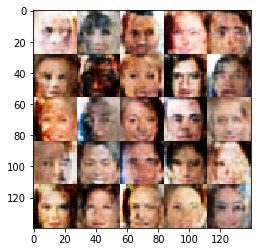

Epoch 1/1 - Batch 1310/6331:  Discriminator Loss: 0.7061 Generator Loss: 2.0389
Epoch 1/1 - Batch 1320/6331:  Discriminator Loss: 0.9539 Generator Loss: 1.1836
Epoch 1/1 - Batch 1330/6331:  Discriminator Loss: 0.8815 Generator Loss: 1.1050
Epoch 1/1 - Batch 1340/6331:  Discriminator Loss: 0.6580 Generator Loss: 2.6873
Epoch 1/1 - Batch 1350/6331:  Discriminator Loss: 0.8285 Generator Loss: 1.3155
Epoch 1/1 - Batch 1360/6331:  Discriminator Loss: 1.1595 Generator Loss: 2.0445
Epoch 1/1 - Batch 1370/6331:  Discriminator Loss: 0.9379 Generator Loss: 2.0851
Epoch 1/1 - Batch 1380/6331:  Discriminator Loss: 0.7487 Generator Loss: 1.4542
Epoch 1/1 - Batch 1390/6331:  Discriminator Loss: 0.6556 Generator Loss: 2.5139
Epoch 1/1 - Batch 1400/6331:  Discriminator Loss: 0.4238 Generator Loss: 4.1652


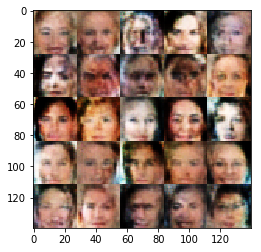

Epoch 1/1 - Batch 1410/6331:  Discriminator Loss: 0.7402 Generator Loss: 1.9490
Epoch 1/1 - Batch 1420/6331:  Discriminator Loss: 0.7610 Generator Loss: 1.6378
Epoch 1/1 - Batch 1430/6331:  Discriminator Loss: 0.8897 Generator Loss: 1.0673
Epoch 1/1 - Batch 1440/6331:  Discriminator Loss: 0.5212 Generator Loss: 3.2608
Epoch 1/1 - Batch 1450/6331:  Discriminator Loss: 0.5331 Generator Loss: 3.3436
Epoch 1/1 - Batch 1460/6331:  Discriminator Loss: 0.6563 Generator Loss: 2.4688
Epoch 1/1 - Batch 1470/6331:  Discriminator Loss: 0.7910 Generator Loss: 1.9690
Epoch 1/1 - Batch 1480/6331:  Discriminator Loss: 0.6961 Generator Loss: 3.4413
Epoch 1/1 - Batch 1490/6331:  Discriminator Loss: 0.5416 Generator Loss: 3.0946
Epoch 1/1 - Batch 1500/6331:  Discriminator Loss: 1.3996 Generator Loss: 1.1583


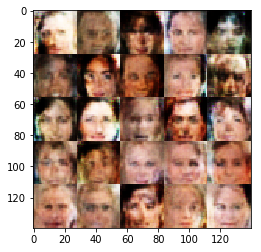

Epoch 1/1 - Batch 1510/6331:  Discriminator Loss: 0.9307 Generator Loss: 1.2616
Epoch 1/1 - Batch 1520/6331:  Discriminator Loss: 0.8184 Generator Loss: 1.6550
Epoch 1/1 - Batch 1530/6331:  Discriminator Loss: 0.7570 Generator Loss: 1.4162
Epoch 1/1 - Batch 1540/6331:  Discriminator Loss: 0.9888 Generator Loss: 0.9751
Epoch 1/1 - Batch 1550/6331:  Discriminator Loss: 0.9153 Generator Loss: 1.0995
Epoch 1/1 - Batch 1560/6331:  Discriminator Loss: 0.9727 Generator Loss: 0.9385
Epoch 1/1 - Batch 1570/6331:  Discriminator Loss: 0.6472 Generator Loss: 2.1752
Epoch 1/1 - Batch 1580/6331:  Discriminator Loss: 0.9141 Generator Loss: 1.1912
Epoch 1/1 - Batch 1590/6331:  Discriminator Loss: 0.8391 Generator Loss: 1.3097
Epoch 1/1 - Batch 1600/6331:  Discriminator Loss: 0.4607 Generator Loss: 4.8997


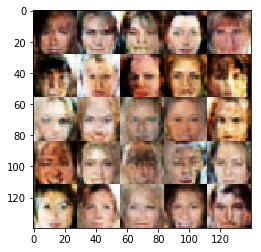

Epoch 1/1 - Batch 1610/6331:  Discriminator Loss: 0.5562 Generator Loss: 3.3325
Epoch 1/1 - Batch 1620/6331:  Discriminator Loss: 0.5752 Generator Loss: 2.7896
Epoch 1/1 - Batch 1630/6331:  Discriminator Loss: 0.7408 Generator Loss: 1.3842
Epoch 1/1 - Batch 1640/6331:  Discriminator Loss: 0.5243 Generator Loss: 3.1141
Epoch 1/1 - Batch 1650/6331:  Discriminator Loss: 0.7696 Generator Loss: 2.9526
Epoch 1/1 - Batch 1660/6331:  Discriminator Loss: 0.6777 Generator Loss: 2.2621
Epoch 1/1 - Batch 1670/6331:  Discriminator Loss: 0.7610 Generator Loss: 2.1222
Epoch 1/1 - Batch 1680/6331:  Discriminator Loss: 1.8382 Generator Loss: 3.2661
Epoch 1/1 - Batch 1690/6331:  Discriminator Loss: 0.6709 Generator Loss: 2.1570
Epoch 1/1 - Batch 1700/6331:  Discriminator Loss: 0.5705 Generator Loss: 2.7535


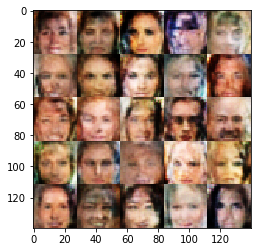

Epoch 1/1 - Batch 1710/6331:  Discriminator Loss: 0.8544 Generator Loss: 1.3480
Epoch 1/1 - Batch 1720/6331:  Discriminator Loss: 0.7429 Generator Loss: 2.0910
Epoch 1/1 - Batch 1730/6331:  Discriminator Loss: 0.7809 Generator Loss: 1.6171
Epoch 1/1 - Batch 1740/6331:  Discriminator Loss: 0.9704 Generator Loss: 1.0713
Epoch 1/1 - Batch 1750/6331:  Discriminator Loss: 0.4662 Generator Loss: 3.6125
Epoch 1/1 - Batch 1760/6331:  Discriminator Loss: 0.6392 Generator Loss: 2.2220
Epoch 1/1 - Batch 1770/6331:  Discriminator Loss: 0.6147 Generator Loss: 1.9207
Epoch 1/1 - Batch 1780/6331:  Discriminator Loss: 0.5955 Generator Loss: 2.6795
Epoch 1/1 - Batch 1790/6331:  Discriminator Loss: 0.5445 Generator Loss: 3.3318
Epoch 1/1 - Batch 1800/6331:  Discriminator Loss: 0.5616 Generator Loss: 3.9242


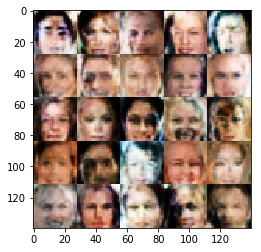

Epoch 1/1 - Batch 1810/6331:  Discriminator Loss: 0.4519 Generator Loss: 3.6294
Epoch 1/1 - Batch 1820/6331:  Discriminator Loss: 0.5074 Generator Loss: 2.8089
Epoch 1/1 - Batch 1830/6331:  Discriminator Loss: 0.4812 Generator Loss: 4.0736
Epoch 1/1 - Batch 1840/6331:  Discriminator Loss: 0.4976 Generator Loss: 2.4245
Epoch 1/1 - Batch 1850/6331:  Discriminator Loss: 0.4461 Generator Loss: 5.0965
Epoch 1/1 - Batch 1860/6331:  Discriminator Loss: 2.9079 Generator Loss: 0.1740
Epoch 1/1 - Batch 1870/6331:  Discriminator Loss: 0.8371 Generator Loss: 1.4864
Epoch 1/1 - Batch 1880/6331:  Discriminator Loss: 1.0585 Generator Loss: 0.9356
Epoch 1/1 - Batch 1890/6331:  Discriminator Loss: 0.8060 Generator Loss: 1.3471
Epoch 1/1 - Batch 1900/6331:  Discriminator Loss: 0.7404 Generator Loss: 2.0349


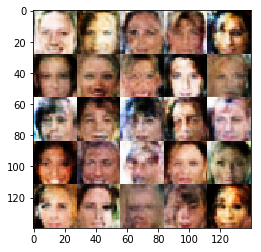

Epoch 1/1 - Batch 1910/6331:  Discriminator Loss: 0.7155 Generator Loss: 1.8393
Epoch 1/1 - Batch 1920/6331:  Discriminator Loss: 0.7344 Generator Loss: 2.2495
Epoch 1/1 - Batch 1930/6331:  Discriminator Loss: 0.7853 Generator Loss: 1.3835
Epoch 1/1 - Batch 1940/6331:  Discriminator Loss: 0.5020 Generator Loss: 3.0036
Epoch 1/1 - Batch 1950/6331:  Discriminator Loss: 0.8678 Generator Loss: 1.0804
Epoch 1/1 - Batch 1960/6331:  Discriminator Loss: 0.8447 Generator Loss: 1.3840
Epoch 1/1 - Batch 1970/6331:  Discriminator Loss: 0.6224 Generator Loss: 3.0210
Epoch 1/1 - Batch 1980/6331:  Discriminator Loss: 1.1110 Generator Loss: 0.9166
Epoch 1/1 - Batch 1990/6331:  Discriminator Loss: 0.7208 Generator Loss: 2.1693
Epoch 1/1 - Batch 2000/6331:  Discriminator Loss: 0.9663 Generator Loss: 1.0200


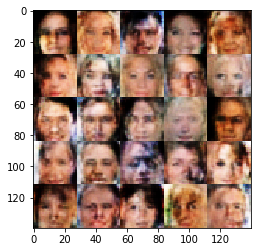

Epoch 1/1 - Batch 2010/6331:  Discriminator Loss: 0.5194 Generator Loss: 2.9094
Epoch 1/1 - Batch 2020/6331:  Discriminator Loss: 0.6248 Generator Loss: 3.6234
Epoch 1/1 - Batch 2030/6331:  Discriminator Loss: 0.6295 Generator Loss: 2.2500
Epoch 1/1 - Batch 2040/6331:  Discriminator Loss: 0.4372 Generator Loss: 3.3723
Epoch 1/1 - Batch 2050/6331:  Discriminator Loss: 0.6297 Generator Loss: 2.7117
Epoch 1/1 - Batch 2060/6331:  Discriminator Loss: 0.5670 Generator Loss: 2.0986
Epoch 1/1 - Batch 2070/6331:  Discriminator Loss: 0.4389 Generator Loss: 4.4086
Epoch 1/1 - Batch 2080/6331:  Discriminator Loss: 0.8370 Generator Loss: 1.2898
Epoch 1/1 - Batch 2090/6331:  Discriminator Loss: 0.9955 Generator Loss: 1.0504
Epoch 1/1 - Batch 2100/6331:  Discriminator Loss: 0.8941 Generator Loss: 1.0906


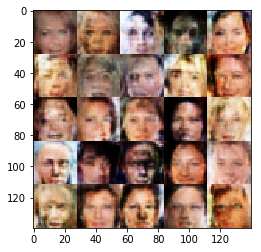

Epoch 1/1 - Batch 2110/6331:  Discriminator Loss: 0.8332 Generator Loss: 1.6370
Epoch 1/1 - Batch 2120/6331:  Discriminator Loss: 0.5488 Generator Loss: 2.6356
Epoch 1/1 - Batch 2130/6331:  Discriminator Loss: 0.8287 Generator Loss: 1.8330
Epoch 1/1 - Batch 2140/6331:  Discriminator Loss: 0.6492 Generator Loss: 2.2311
Epoch 1/1 - Batch 2150/6331:  Discriminator Loss: 0.8063 Generator Loss: 1.8943
Epoch 1/1 - Batch 2160/6331:  Discriminator Loss: 0.9572 Generator Loss: 1.7601
Epoch 1/1 - Batch 2170/6331:  Discriminator Loss: 0.8529 Generator Loss: 2.0196
Epoch 1/1 - Batch 2180/6331:  Discriminator Loss: 0.9081 Generator Loss: 1.1868
Epoch 1/1 - Batch 2190/6331:  Discriminator Loss: 0.7874 Generator Loss: 1.6137
Epoch 1/1 - Batch 2200/6331:  Discriminator Loss: 0.7596 Generator Loss: 1.5289


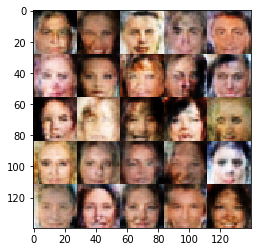

Epoch 1/1 - Batch 2210/6331:  Discriminator Loss: 0.8877 Generator Loss: 1.5450
Epoch 1/1 - Batch 2220/6331:  Discriminator Loss: 0.5644 Generator Loss: 2.9863
Epoch 1/1 - Batch 2230/6331:  Discriminator Loss: 0.5330 Generator Loss: 2.6340
Epoch 1/1 - Batch 2240/6331:  Discriminator Loss: 0.6818 Generator Loss: 2.9807
Epoch 1/1 - Batch 2250/6331:  Discriminator Loss: 2.3061 Generator Loss: 0.3232
Epoch 1/1 - Batch 2260/6331:  Discriminator Loss: 0.8912 Generator Loss: 1.1061
Epoch 1/1 - Batch 2270/6331:  Discriminator Loss: 0.6336 Generator Loss: 1.9562
Epoch 1/1 - Batch 2280/6331:  Discriminator Loss: 0.5451 Generator Loss: 3.3328
Epoch 1/1 - Batch 2290/6331:  Discriminator Loss: 0.8830 Generator Loss: 2.1561
Epoch 1/1 - Batch 2300/6331:  Discriminator Loss: 1.3151 Generator Loss: 3.5272


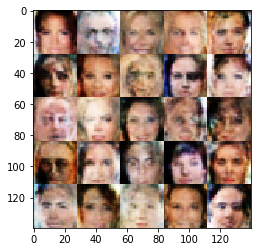

Epoch 1/1 - Batch 2310/6331:  Discriminator Loss: 0.5785 Generator Loss: 2.3521
Epoch 1/1 - Batch 2320/6331:  Discriminator Loss: 0.6040 Generator Loss: 1.8583
Epoch 1/1 - Batch 2330/6331:  Discriminator Loss: 0.7028 Generator Loss: 1.7248
Epoch 1/1 - Batch 2340/6331:  Discriminator Loss: 0.4320 Generator Loss: 3.8344
Epoch 1/1 - Batch 2350/6331:  Discriminator Loss: 0.8562 Generator Loss: 1.1653
Epoch 1/1 - Batch 2360/6331:  Discriminator Loss: 1.1048 Generator Loss: 0.7408
Epoch 1/1 - Batch 2370/6331:  Discriminator Loss: 0.7726 Generator Loss: 1.8511
Epoch 1/1 - Batch 2380/6331:  Discriminator Loss: 0.5322 Generator Loss: 2.8909
Epoch 1/1 - Batch 2390/6331:  Discriminator Loss: 1.2919 Generator Loss: 3.1096
Epoch 1/1 - Batch 2400/6331:  Discriminator Loss: 1.0611 Generator Loss: 0.8798


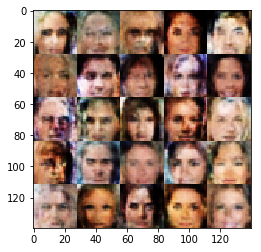

Epoch 1/1 - Batch 2410/6331:  Discriminator Loss: 1.0556 Generator Loss: 1.0201
Epoch 1/1 - Batch 2420/6331:  Discriminator Loss: 1.0266 Generator Loss: 0.9627
Epoch 1/1 - Batch 2430/6331:  Discriminator Loss: 0.8273 Generator Loss: 1.2480
Epoch 1/1 - Batch 2440/6331:  Discriminator Loss: 0.8212 Generator Loss: 1.3128
Epoch 1/1 - Batch 2450/6331:  Discriminator Loss: 0.5477 Generator Loss: 2.3266
Epoch 1/1 - Batch 2460/6331:  Discriminator Loss: 0.6376 Generator Loss: 2.1471
Epoch 1/1 - Batch 2470/6331:  Discriminator Loss: 0.6017 Generator Loss: 2.0792
Epoch 1/1 - Batch 2480/6331:  Discriminator Loss: 0.6485 Generator Loss: 3.1182
Epoch 1/1 - Batch 2490/6331:  Discriminator Loss: 0.7582 Generator Loss: 1.4857
Epoch 1/1 - Batch 2500/6331:  Discriminator Loss: 0.9426 Generator Loss: 3.7458


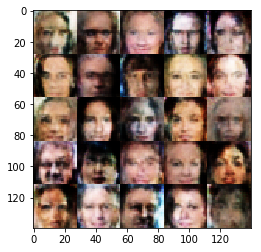

Epoch 1/1 - Batch 2510/6331:  Discriminator Loss: 0.7380 Generator Loss: 1.3874
Epoch 1/1 - Batch 2520/6331:  Discriminator Loss: 0.4527 Generator Loss: 4.1330
Epoch 1/1 - Batch 2530/6331:  Discriminator Loss: 0.7044 Generator Loss: 1.6049
Epoch 1/1 - Batch 2540/6331:  Discriminator Loss: 0.8639 Generator Loss: 1.1468
Epoch 1/1 - Batch 2550/6331:  Discriminator Loss: 0.3744 Generator Loss: 10.1662
Epoch 1/1 - Batch 2560/6331:  Discriminator Loss: 0.6080 Generator Loss: 4.9828
Epoch 1/1 - Batch 2570/6331:  Discriminator Loss: 0.6220 Generator Loss: 1.7529
Epoch 1/1 - Batch 2580/6331:  Discriminator Loss: 0.4607 Generator Loss: 4.8756
Epoch 1/1 - Batch 2590/6331:  Discriminator Loss: 0.4725 Generator Loss: 4.1735
Epoch 1/1 - Batch 2600/6331:  Discriminator Loss: 0.8951 Generator Loss: 1.1991


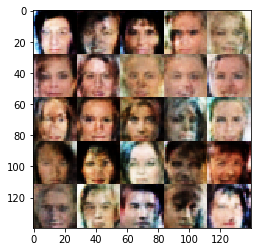

Epoch 1/1 - Batch 2610/6331:  Discriminator Loss: 1.0734 Generator Loss: 0.9061
Epoch 1/1 - Batch 2620/6331:  Discriminator Loss: 0.7502 Generator Loss: 2.4178
Epoch 1/1 - Batch 2630/6331:  Discriminator Loss: 0.8316 Generator Loss: 1.2842
Epoch 1/1 - Batch 2640/6331:  Discriminator Loss: 0.6879 Generator Loss: 1.6182
Epoch 1/1 - Batch 2650/6331:  Discriminator Loss: 0.9936 Generator Loss: 0.9030
Epoch 1/1 - Batch 2660/6331:  Discriminator Loss: 0.5631 Generator Loss: 2.1722
Epoch 1/1 - Batch 2670/6331:  Discriminator Loss: 0.6300 Generator Loss: 1.9359
Epoch 1/1 - Batch 2680/6331:  Discriminator Loss: 1.4855 Generator Loss: 0.6035
Epoch 1/1 - Batch 2690/6331:  Discriminator Loss: 0.6406 Generator Loss: 1.9654
Epoch 1/1 - Batch 2700/6331:  Discriminator Loss: 0.6626 Generator Loss: 1.7263


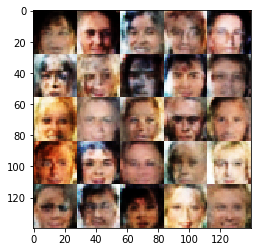

Epoch 1/1 - Batch 2710/6331:  Discriminator Loss: 0.7529 Generator Loss: 4.3287
Epoch 1/1 - Batch 2720/6331:  Discriminator Loss: 0.8042 Generator Loss: 1.6095
Epoch 1/1 - Batch 2730/6331:  Discriminator Loss: 0.5256 Generator Loss: 2.8291
Epoch 1/1 - Batch 2740/6331:  Discriminator Loss: 0.7872 Generator Loss: 1.6415
Epoch 1/1 - Batch 2750/6331:  Discriminator Loss: 0.6321 Generator Loss: 2.0724
Epoch 1/1 - Batch 2760/6331:  Discriminator Loss: 0.7234 Generator Loss: 1.6285
Epoch 1/1 - Batch 2770/6331:  Discriminator Loss: 1.2989 Generator Loss: 0.7597
Epoch 1/1 - Batch 2780/6331:  Discriminator Loss: 0.6745 Generator Loss: 2.3046
Epoch 1/1 - Batch 2790/6331:  Discriminator Loss: 0.6247 Generator Loss: 2.0333
Epoch 1/1 - Batch 2800/6331:  Discriminator Loss: 0.7676 Generator Loss: 1.5165


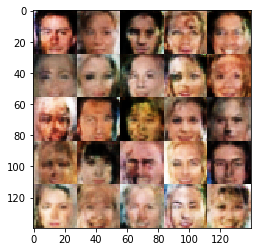

Epoch 1/1 - Batch 2810/6331:  Discriminator Loss: 1.1133 Generator Loss: 1.8992
Epoch 1/1 - Batch 2820/6331:  Discriminator Loss: 0.9726 Generator Loss: 0.8980
Epoch 1/1 - Batch 2830/6331:  Discriminator Loss: 0.4740 Generator Loss: 3.0780
Epoch 1/1 - Batch 2840/6331:  Discriminator Loss: 0.5439 Generator Loss: 2.4315
Epoch 1/1 - Batch 2850/6331:  Discriminator Loss: 1.0394 Generator Loss: 1.7613
Epoch 1/1 - Batch 2860/6331:  Discriminator Loss: 0.7731 Generator Loss: 1.4846
Epoch 1/1 - Batch 2870/6331:  Discriminator Loss: 0.5443 Generator Loss: 2.5932
Epoch 1/1 - Batch 2880/6331:  Discriminator Loss: 0.9601 Generator Loss: 1.0443
Epoch 1/1 - Batch 2890/6331:  Discriminator Loss: 0.6542 Generator Loss: 1.8875
Epoch 1/1 - Batch 2900/6331:  Discriminator Loss: 0.6327 Generator Loss: 2.4030


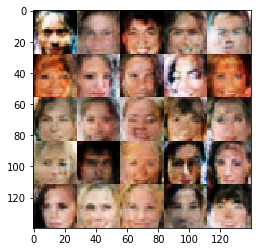

Epoch 1/1 - Batch 2910/6331:  Discriminator Loss: 0.7135 Generator Loss: 1.7264
Epoch 1/1 - Batch 2920/6331:  Discriminator Loss: 0.5841 Generator Loss: 2.6259
Epoch 1/1 - Batch 2930/6331:  Discriminator Loss: 0.6622 Generator Loss: 1.9116
Epoch 1/1 - Batch 2940/6331:  Discriminator Loss: 0.6948 Generator Loss: 1.6372
Epoch 1/1 - Batch 2950/6331:  Discriminator Loss: 1.3117 Generator Loss: 0.6838
Epoch 1/1 - Batch 2960/6331:  Discriminator Loss: 1.0008 Generator Loss: 0.9401
Epoch 1/1 - Batch 2970/6331:  Discriminator Loss: 0.7700 Generator Loss: 1.6853
Epoch 1/1 - Batch 2980/6331:  Discriminator Loss: 0.8583 Generator Loss: 1.5036
Epoch 1/1 - Batch 2990/6331:  Discriminator Loss: 0.6508 Generator Loss: 2.1050
Epoch 1/1 - Batch 3000/6331:  Discriminator Loss: 0.7113 Generator Loss: 1.6678


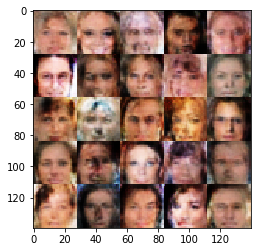

Epoch 1/1 - Batch 3010/6331:  Discriminator Loss: 0.5653 Generator Loss: 2.9378
Epoch 1/1 - Batch 3020/6331:  Discriminator Loss: 0.8613 Generator Loss: 1.1985
Epoch 1/1 - Batch 3030/6331:  Discriminator Loss: 1.0070 Generator Loss: 0.8817
Epoch 1/1 - Batch 3040/6331:  Discriminator Loss: 0.5031 Generator Loss: 3.0293
Epoch 1/1 - Batch 3050/6331:  Discriminator Loss: 1.0715 Generator Loss: 0.9857
Epoch 1/1 - Batch 3060/6331:  Discriminator Loss: 1.0335 Generator Loss: 0.9074
Epoch 1/1 - Batch 3070/6331:  Discriminator Loss: 0.8815 Generator Loss: 1.0554
Epoch 1/1 - Batch 3080/6331:  Discriminator Loss: 0.4830 Generator Loss: 3.4911
Epoch 1/1 - Batch 3090/6331:  Discriminator Loss: 0.4979 Generator Loss: 2.9002
Epoch 1/1 - Batch 3100/6331:  Discriminator Loss: 0.8490 Generator Loss: 1.3283


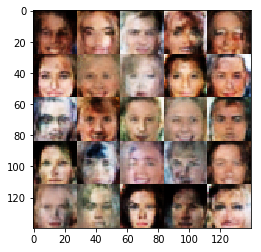

Epoch 1/1 - Batch 3110/6331:  Discriminator Loss: 0.4536 Generator Loss: 3.2047
Epoch 1/1 - Batch 3120/6331:  Discriminator Loss: 0.6120 Generator Loss: 3.5180
Epoch 1/1 - Batch 3130/6331:  Discriminator Loss: 0.5341 Generator Loss: 3.7915
Epoch 1/1 - Batch 3140/6331:  Discriminator Loss: 1.0613 Generator Loss: 0.8785
Epoch 1/1 - Batch 3150/6331:  Discriminator Loss: 0.8185 Generator Loss: 1.3172
Epoch 1/1 - Batch 3160/6331:  Discriminator Loss: 0.5577 Generator Loss: 2.7900
Epoch 1/1 - Batch 3170/6331:  Discriminator Loss: 1.0419 Generator Loss: 1.2537
Epoch 1/1 - Batch 3180/6331:  Discriminator Loss: 0.5974 Generator Loss: 2.6444
Epoch 1/1 - Batch 3190/6331:  Discriminator Loss: 0.7583 Generator Loss: 1.8023
Epoch 1/1 - Batch 3200/6331:  Discriminator Loss: 1.4989 Generator Loss: 0.5234


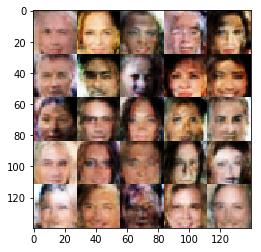

Epoch 1/1 - Batch 3210/6331:  Discriminator Loss: 0.5284 Generator Loss: 2.9302
Epoch 1/1 - Batch 3220/6331:  Discriminator Loss: 0.6553 Generator Loss: 2.3152
Epoch 1/1 - Batch 3230/6331:  Discriminator Loss: 1.3046 Generator Loss: 0.7028
Epoch 1/1 - Batch 3240/6331:  Discriminator Loss: 0.6709 Generator Loss: 2.1885
Epoch 1/1 - Batch 3250/6331:  Discriminator Loss: 0.6649 Generator Loss: 2.0351
Epoch 1/1 - Batch 3260/6331:  Discriminator Loss: 0.5478 Generator Loss: 2.6115
Epoch 1/1 - Batch 3270/6331:  Discriminator Loss: 1.0258 Generator Loss: 0.9381
Epoch 1/1 - Batch 3280/6331:  Discriminator Loss: 0.7776 Generator Loss: 1.6842
Epoch 1/1 - Batch 3290/6331:  Discriminator Loss: 0.7858 Generator Loss: 1.8086
Epoch 1/1 - Batch 3300/6331:  Discriminator Loss: 0.5730 Generator Loss: 2.0575


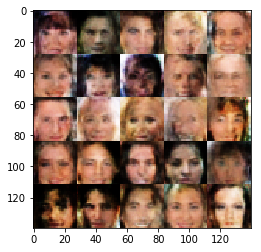

Epoch 1/1 - Batch 3310/6331:  Discriminator Loss: 1.5571 Generator Loss: 0.5885
Epoch 1/1 - Batch 3320/6331:  Discriminator Loss: 0.5273 Generator Loss: 2.4811
Epoch 1/1 - Batch 3330/6331:  Discriminator Loss: 0.6564 Generator Loss: 2.7493
Epoch 1/1 - Batch 3340/6331:  Discriminator Loss: 0.8400 Generator Loss: 1.2819
Epoch 1/1 - Batch 3350/6331:  Discriminator Loss: 0.6956 Generator Loss: 2.0168
Epoch 1/1 - Batch 3360/6331:  Discriminator Loss: 0.5347 Generator Loss: 2.6884
Epoch 1/1 - Batch 3370/6331:  Discriminator Loss: 0.7020 Generator Loss: 2.3725
Epoch 1/1 - Batch 3380/6331:  Discriminator Loss: 0.9733 Generator Loss: 1.1135
Epoch 1/1 - Batch 3390/6331:  Discriminator Loss: 0.8117 Generator Loss: 2.2814
Epoch 1/1 - Batch 3400/6331:  Discriminator Loss: 0.4752 Generator Loss: 2.7832


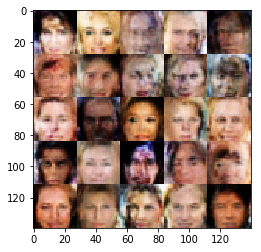

Epoch 1/1 - Batch 3410/6331:  Discriminator Loss: 0.8169 Generator Loss: 2.0944
Epoch 1/1 - Batch 3420/6331:  Discriminator Loss: 0.4561 Generator Loss: 3.2988
Epoch 1/1 - Batch 3430/6331:  Discriminator Loss: 0.5381 Generator Loss: 3.1649
Epoch 1/1 - Batch 3440/6331:  Discriminator Loss: 0.7466 Generator Loss: 1.6867
Epoch 1/1 - Batch 3450/6331:  Discriminator Loss: 0.9873 Generator Loss: 1.0952
Epoch 1/1 - Batch 3460/6331:  Discriminator Loss: 0.7231 Generator Loss: 1.6056
Epoch 1/1 - Batch 3470/6331:  Discriminator Loss: 0.5523 Generator Loss: 2.9148
Epoch 1/1 - Batch 3480/6331:  Discriminator Loss: 0.5643 Generator Loss: 2.4062
Epoch 1/1 - Batch 3490/6331:  Discriminator Loss: 0.8762 Generator Loss: 1.2287
Epoch 1/1 - Batch 3500/6331:  Discriminator Loss: 0.9678 Generator Loss: 1.6353


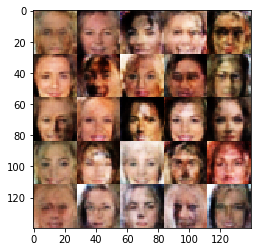

Epoch 1/1 - Batch 3510/6331:  Discriminator Loss: 0.6954 Generator Loss: 2.7817
Epoch 1/1 - Batch 3520/6331:  Discriminator Loss: 0.7012 Generator Loss: 1.5350
Epoch 1/1 - Batch 3530/6331:  Discriminator Loss: 0.8138 Generator Loss: 1.2753
Epoch 1/1 - Batch 3540/6331:  Discriminator Loss: 0.9079 Generator Loss: 1.5940
Epoch 1/1 - Batch 3550/6331:  Discriminator Loss: 0.8783 Generator Loss: 2.0381
Epoch 1/1 - Batch 3560/6331:  Discriminator Loss: 0.9530 Generator Loss: 2.2271
Epoch 1/1 - Batch 3570/6331:  Discriminator Loss: 0.6378 Generator Loss: 1.6986
Epoch 1/1 - Batch 3580/6331:  Discriminator Loss: 1.1115 Generator Loss: 2.9126
Epoch 1/1 - Batch 3590/6331:  Discriminator Loss: 0.8070 Generator Loss: 1.3057
Epoch 1/1 - Batch 3600/6331:  Discriminator Loss: 0.7055 Generator Loss: 2.2192


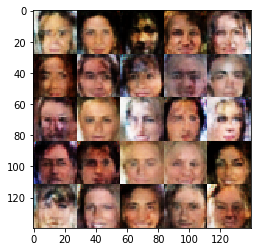

Epoch 1/1 - Batch 3610/6331:  Discriminator Loss: 0.8004 Generator Loss: 1.6468
Epoch 1/1 - Batch 3620/6331:  Discriminator Loss: 0.8192 Generator Loss: 1.7768
Epoch 1/1 - Batch 3630/6331:  Discriminator Loss: 0.7019 Generator Loss: 1.8332
Epoch 1/1 - Batch 3640/6331:  Discriminator Loss: 0.5039 Generator Loss: 3.6173
Epoch 1/1 - Batch 3650/6331:  Discriminator Loss: 0.5607 Generator Loss: 3.8176
Epoch 1/1 - Batch 3660/6331:  Discriminator Loss: 0.8101 Generator Loss: 1.3134
Epoch 1/1 - Batch 3670/6331:  Discriminator Loss: 0.6677 Generator Loss: 2.2941
Epoch 1/1 - Batch 3680/6331:  Discriminator Loss: 0.6345 Generator Loss: 2.8784
Epoch 1/1 - Batch 3690/6331:  Discriminator Loss: 0.7111 Generator Loss: 2.2872
Epoch 1/1 - Batch 3700/6331:  Discriminator Loss: 0.4875 Generator Loss: 2.8562


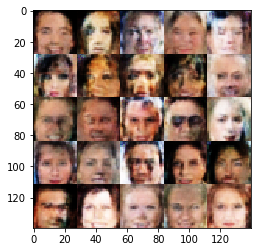

Epoch 1/1 - Batch 3710/6331:  Discriminator Loss: 1.0529 Generator Loss: 1.1772
Epoch 1/1 - Batch 3720/6331:  Discriminator Loss: 0.8479 Generator Loss: 1.5355
Epoch 1/1 - Batch 3730/6331:  Discriminator Loss: 0.6393 Generator Loss: 2.5122
Epoch 1/1 - Batch 3740/6331:  Discriminator Loss: 0.9725 Generator Loss: 2.3455
Epoch 1/1 - Batch 3750/6331:  Discriminator Loss: 0.7805 Generator Loss: 1.5848
Epoch 1/1 - Batch 3760/6331:  Discriminator Loss: 0.8760 Generator Loss: 1.2432
Epoch 1/1 - Batch 3770/6331:  Discriminator Loss: 0.7991 Generator Loss: 1.9229
Epoch 1/1 - Batch 3780/6331:  Discriminator Loss: 0.8948 Generator Loss: 1.2185
Epoch 1/1 - Batch 3790/6331:  Discriminator Loss: 0.7194 Generator Loss: 1.7947
Epoch 1/1 - Batch 3800/6331:  Discriminator Loss: 0.7132 Generator Loss: 1.6451


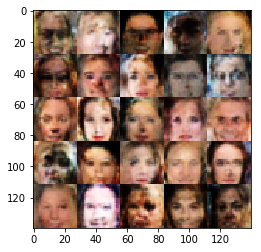

Epoch 1/1 - Batch 3810/6331:  Discriminator Loss: 0.6164 Generator Loss: 3.0735
Epoch 1/1 - Batch 3820/6331:  Discriminator Loss: 0.8474 Generator Loss: 1.2792
Epoch 1/1 - Batch 3830/6331:  Discriminator Loss: 0.7609 Generator Loss: 1.4309
Epoch 1/1 - Batch 3840/6331:  Discriminator Loss: 0.5608 Generator Loss: 2.3006
Epoch 1/1 - Batch 3850/6331:  Discriminator Loss: 0.8473 Generator Loss: 2.2483
Epoch 1/1 - Batch 3860/6331:  Discriminator Loss: 0.9075 Generator Loss: 1.0751
Epoch 1/1 - Batch 3870/6331:  Discriminator Loss: 0.8074 Generator Loss: 1.5786
Epoch 1/1 - Batch 3880/6331:  Discriminator Loss: 0.8567 Generator Loss: 1.4709
Epoch 1/1 - Batch 3890/6331:  Discriminator Loss: 0.8624 Generator Loss: 1.5306
Epoch 1/1 - Batch 3900/6331:  Discriminator Loss: 0.9778 Generator Loss: 1.0640


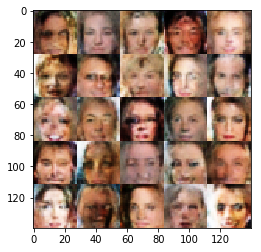

Epoch 1/1 - Batch 3910/6331:  Discriminator Loss: 0.8789 Generator Loss: 1.1267
Epoch 1/1 - Batch 3920/6331:  Discriminator Loss: 0.4491 Generator Loss: 6.0392
Epoch 1/1 - Batch 3930/6331:  Discriminator Loss: 0.7044 Generator Loss: 1.6314
Epoch 1/1 - Batch 3940/6331:  Discriminator Loss: 0.6576 Generator Loss: 3.1166
Epoch 1/1 - Batch 3950/6331:  Discriminator Loss: 0.5675 Generator Loss: 2.5410
Epoch 1/1 - Batch 3960/6331:  Discriminator Loss: 1.1903 Generator Loss: 1.3834
Epoch 1/1 - Batch 3970/6331:  Discriminator Loss: 1.1782 Generator Loss: 1.5733
Epoch 1/1 - Batch 3980/6331:  Discriminator Loss: 0.8200 Generator Loss: 1.4777
Epoch 1/1 - Batch 3990/6331:  Discriminator Loss: 0.7103 Generator Loss: 1.7465
Epoch 1/1 - Batch 4000/6331:  Discriminator Loss: 0.6544 Generator Loss: 1.9688


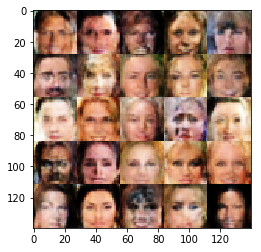

Epoch 1/1 - Batch 4010/6331:  Discriminator Loss: 0.7274 Generator Loss: 1.5731
Epoch 1/1 - Batch 4020/6331:  Discriminator Loss: 1.0420 Generator Loss: 0.8907
Epoch 1/1 - Batch 4030/6331:  Discriminator Loss: 0.5930 Generator Loss: 3.0186
Epoch 1/1 - Batch 4040/6331:  Discriminator Loss: 0.5114 Generator Loss: 3.2177
Epoch 1/1 - Batch 4050/6331:  Discriminator Loss: 0.5703 Generator Loss: 3.1095
Epoch 1/1 - Batch 4060/6331:  Discriminator Loss: 0.6758 Generator Loss: 2.3724
Epoch 1/1 - Batch 4070/6331:  Discriminator Loss: 0.6504 Generator Loss: 1.9292
Epoch 1/1 - Batch 4080/6331:  Discriminator Loss: 0.8281 Generator Loss: 1.9602
Epoch 1/1 - Batch 4090/6331:  Discriminator Loss: 0.9233 Generator Loss: 1.5119
Epoch 1/1 - Batch 4100/6331:  Discriminator Loss: 0.9313 Generator Loss: 1.3981


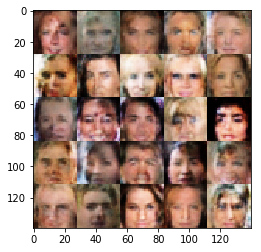

Epoch 1/1 - Batch 4110/6331:  Discriminator Loss: 0.9911 Generator Loss: 1.6915
Epoch 1/1 - Batch 4120/6331:  Discriminator Loss: 0.7461 Generator Loss: 1.4663
Epoch 1/1 - Batch 4130/6331:  Discriminator Loss: 0.7519 Generator Loss: 1.6193
Epoch 1/1 - Batch 4140/6331:  Discriminator Loss: 0.6059 Generator Loss: 3.0165
Epoch 1/1 - Batch 4150/6331:  Discriminator Loss: 0.8018 Generator Loss: 1.3806
Epoch 1/1 - Batch 4160/6331:  Discriminator Loss: 0.5867 Generator Loss: 2.5621
Epoch 1/1 - Batch 4170/6331:  Discriminator Loss: 0.9156 Generator Loss: 1.3681
Epoch 1/1 - Batch 4180/6331:  Discriminator Loss: 0.8848 Generator Loss: 1.1275
Epoch 1/1 - Batch 4190/6331:  Discriminator Loss: 0.7092 Generator Loss: 2.3860
Epoch 1/1 - Batch 4200/6331:  Discriminator Loss: 0.8576 Generator Loss: 1.3018


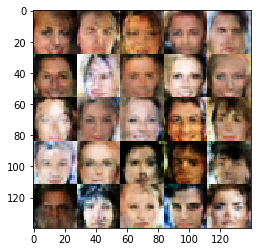

Epoch 1/1 - Batch 4210/6331:  Discriminator Loss: 0.9954 Generator Loss: 1.0179
Epoch 1/1 - Batch 4220/6331:  Discriminator Loss: 1.4557 Generator Loss: 0.6077
Epoch 1/1 - Batch 4230/6331:  Discriminator Loss: 0.8134 Generator Loss: 1.3727
Epoch 1/1 - Batch 4240/6331:  Discriminator Loss: 0.7848 Generator Loss: 1.5363
Epoch 1/1 - Batch 4250/6331:  Discriminator Loss: 0.7013 Generator Loss: 1.9842
Epoch 1/1 - Batch 4260/6331:  Discriminator Loss: 0.7302 Generator Loss: 2.5479
Epoch 1/1 - Batch 4270/6331:  Discriminator Loss: 0.8692 Generator Loss: 1.6958
Epoch 1/1 - Batch 4280/6331:  Discriminator Loss: 0.7679 Generator Loss: 1.3821
Epoch 1/1 - Batch 4290/6331:  Discriminator Loss: 0.8931 Generator Loss: 1.0756
Epoch 1/1 - Batch 4300/6331:  Discriminator Loss: 0.7468 Generator Loss: 1.3015


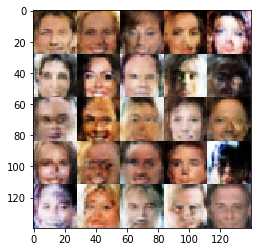

Epoch 1/1 - Batch 4310/6331:  Discriminator Loss: 0.6569 Generator Loss: 1.7717
Epoch 1/1 - Batch 4320/6331:  Discriminator Loss: 0.7027 Generator Loss: 1.7192
Epoch 1/1 - Batch 4330/6331:  Discriminator Loss: 1.0450 Generator Loss: 0.9723
Epoch 1/1 - Batch 4340/6331:  Discriminator Loss: 1.0279 Generator Loss: 0.9513
Epoch 1/1 - Batch 4350/6331:  Discriminator Loss: 0.8881 Generator Loss: 1.1146
Epoch 1/1 - Batch 4360/6331:  Discriminator Loss: 0.6652 Generator Loss: 1.8689
Epoch 1/1 - Batch 4370/6331:  Discriminator Loss: 0.8807 Generator Loss: 1.3424
Epoch 1/1 - Batch 4380/6331:  Discriminator Loss: 1.3396 Generator Loss: 0.6126
Epoch 1/1 - Batch 4390/6331:  Discriminator Loss: 0.8776 Generator Loss: 2.7097
Epoch 1/1 - Batch 4400/6331:  Discriminator Loss: 0.8465 Generator Loss: 2.0790


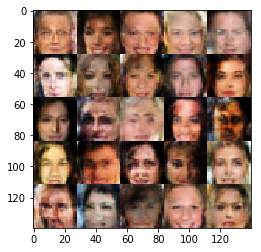

Epoch 1/1 - Batch 4410/6331:  Discriminator Loss: 0.9435 Generator Loss: 1.1247
Epoch 1/1 - Batch 4420/6331:  Discriminator Loss: 0.9776 Generator Loss: 2.4038
Epoch 1/1 - Batch 4430/6331:  Discriminator Loss: 0.7357 Generator Loss: 1.6124
Epoch 1/1 - Batch 4440/6331:  Discriminator Loss: 0.9721 Generator Loss: 0.9460
Epoch 1/1 - Batch 4450/6331:  Discriminator Loss: 0.7293 Generator Loss: 1.4912
Epoch 1/1 - Batch 4460/6331:  Discriminator Loss: 1.4816 Generator Loss: 0.6638
Epoch 1/1 - Batch 4470/6331:  Discriminator Loss: 1.0643 Generator Loss: 1.3972
Epoch 1/1 - Batch 4480/6331:  Discriminator Loss: 0.8754 Generator Loss: 1.2554
Epoch 1/1 - Batch 4490/6331:  Discriminator Loss: 0.8186 Generator Loss: 1.2026
Epoch 1/1 - Batch 4500/6331:  Discriminator Loss: 1.0490 Generator Loss: 0.8962


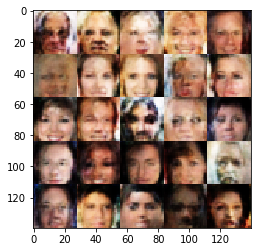

Epoch 1/1 - Batch 4510/6331:  Discriminator Loss: 0.6762 Generator Loss: 3.4141
Epoch 1/1 - Batch 4520/6331:  Discriminator Loss: 0.6484 Generator Loss: 2.1760
Epoch 1/1 - Batch 4530/6331:  Discriminator Loss: 0.7763 Generator Loss: 1.3673
Epoch 1/1 - Batch 4540/6331:  Discriminator Loss: 0.8001 Generator Loss: 1.3012
Epoch 1/1 - Batch 4550/6331:  Discriminator Loss: 0.7519 Generator Loss: 1.5286
Epoch 1/1 - Batch 4560/6331:  Discriminator Loss: 0.9122 Generator Loss: 3.6831
Epoch 1/1 - Batch 4570/6331:  Discriminator Loss: 0.8564 Generator Loss: 1.2822
Epoch 1/1 - Batch 4580/6331:  Discriminator Loss: 0.9721 Generator Loss: 1.0645
Epoch 1/1 - Batch 4590/6331:  Discriminator Loss: 0.9013 Generator Loss: 1.1114
Epoch 1/1 - Batch 4600/6331:  Discriminator Loss: 0.7257 Generator Loss: 2.0175


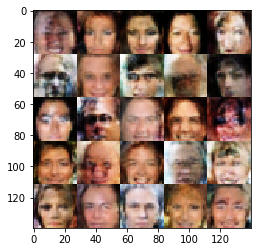

Epoch 1/1 - Batch 4610/6331:  Discriminator Loss: 0.6298 Generator Loss: 3.0052
Epoch 1/1 - Batch 4620/6331:  Discriminator Loss: 0.9937 Generator Loss: 0.9360
Epoch 1/1 - Batch 4630/6331:  Discriminator Loss: 0.9939 Generator Loss: 1.1570
Epoch 1/1 - Batch 4640/6331:  Discriminator Loss: 0.8157 Generator Loss: 2.0794
Epoch 1/1 - Batch 4650/6331:  Discriminator Loss: 0.8226 Generator Loss: 1.2563
Epoch 1/1 - Batch 4660/6331:  Discriminator Loss: 0.7033 Generator Loss: 2.1766
Epoch 1/1 - Batch 4670/6331:  Discriminator Loss: 0.7722 Generator Loss: 1.3658
Epoch 1/1 - Batch 4680/6331:  Discriminator Loss: 0.7743 Generator Loss: 1.5438
Epoch 1/1 - Batch 4690/6331:  Discriminator Loss: 0.7704 Generator Loss: 1.3680
Epoch 1/1 - Batch 4700/6331:  Discriminator Loss: 1.0742 Generator Loss: 0.9929


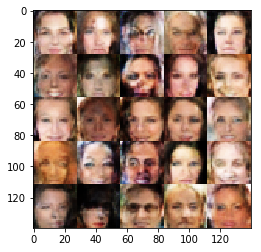

Epoch 1/1 - Batch 4710/6331:  Discriminator Loss: 0.8112 Generator Loss: 1.5152
Epoch 1/1 - Batch 4720/6331:  Discriminator Loss: 0.6404 Generator Loss: 1.8127
Epoch 1/1 - Batch 4730/6331:  Discriminator Loss: 0.7753 Generator Loss: 1.8987
Epoch 1/1 - Batch 4740/6331:  Discriminator Loss: 0.7620 Generator Loss: 1.5432
Epoch 1/1 - Batch 4750/6331:  Discriminator Loss: 0.9703 Generator Loss: 1.0045
Epoch 1/1 - Batch 4760/6331:  Discriminator Loss: 0.7437 Generator Loss: 1.7560
Epoch 1/1 - Batch 4770/6331:  Discriminator Loss: 0.8909 Generator Loss: 1.3191
Epoch 1/1 - Batch 4780/6331:  Discriminator Loss: 0.7425 Generator Loss: 1.6958
Epoch 1/1 - Batch 4790/6331:  Discriminator Loss: 0.6384 Generator Loss: 1.7314
Epoch 1/1 - Batch 4800/6331:  Discriminator Loss: 0.8047 Generator Loss: 1.8692


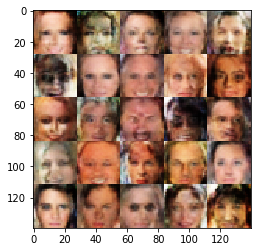

Epoch 1/1 - Batch 4810/6331:  Discriminator Loss: 0.8022 Generator Loss: 2.2204
Epoch 1/1 - Batch 4820/6331:  Discriminator Loss: 1.4503 Generator Loss: 0.4899
Epoch 1/1 - Batch 4830/6331:  Discriminator Loss: 0.8619 Generator Loss: 1.1326
Epoch 1/1 - Batch 4840/6331:  Discriminator Loss: 1.0156 Generator Loss: 0.9248
Epoch 1/1 - Batch 4850/6331:  Discriminator Loss: 0.6356 Generator Loss: 2.1372
Epoch 1/1 - Batch 4860/6331:  Discriminator Loss: 0.8536 Generator Loss: 1.1539
Epoch 1/1 - Batch 4870/6331:  Discriminator Loss: 0.9102 Generator Loss: 1.1654
Epoch 1/1 - Batch 4880/6331:  Discriminator Loss: 0.8080 Generator Loss: 1.2424
Epoch 1/1 - Batch 4890/6331:  Discriminator Loss: 1.0417 Generator Loss: 0.8420
Epoch 1/1 - Batch 4900/6331:  Discriminator Loss: 0.6897 Generator Loss: 2.0594


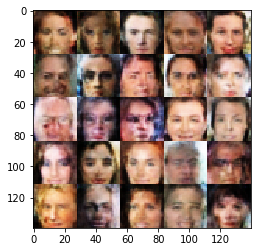

Epoch 1/1 - Batch 4910/6331:  Discriminator Loss: 0.6423 Generator Loss: 2.2528
Epoch 1/1 - Batch 4920/6331:  Discriminator Loss: 0.9410 Generator Loss: 1.0441
Epoch 1/1 - Batch 4930/6331:  Discriminator Loss: 0.7486 Generator Loss: 1.7995
Epoch 1/1 - Batch 4940/6331:  Discriminator Loss: 0.9137 Generator Loss: 1.1551
Epoch 1/1 - Batch 4950/6331:  Discriminator Loss: 0.7702 Generator Loss: 1.6408
Epoch 1/1 - Batch 4960/6331:  Discriminator Loss: 1.3359 Generator Loss: 0.6174
Epoch 1/1 - Batch 4970/6331:  Discriminator Loss: 0.8323 Generator Loss: 1.4576
Epoch 1/1 - Batch 4980/6331:  Discriminator Loss: 0.7914 Generator Loss: 1.5765
Epoch 1/1 - Batch 4990/6331:  Discriminator Loss: 0.7004 Generator Loss: 1.8826
Epoch 1/1 - Batch 5000/6331:  Discriminator Loss: 1.1868 Generator Loss: 2.7605


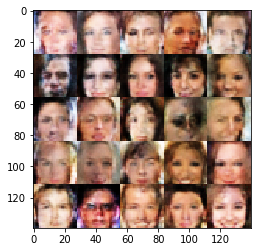

Epoch 1/1 - Batch 5010/6331:  Discriminator Loss: 1.0351 Generator Loss: 0.8919
Epoch 1/1 - Batch 5020/6331:  Discriminator Loss: 1.2846 Generator Loss: 2.7531
Epoch 1/1 - Batch 5030/6331:  Discriminator Loss: 0.8422 Generator Loss: 1.3644
Epoch 1/1 - Batch 5040/6331:  Discriminator Loss: 0.8271 Generator Loss: 1.6526
Epoch 1/1 - Batch 5050/6331:  Discriminator Loss: 0.6159 Generator Loss: 2.3383
Epoch 1/1 - Batch 5060/6331:  Discriminator Loss: 1.0224 Generator Loss: 1.1169
Epoch 1/1 - Batch 5070/6331:  Discriminator Loss: 0.5921 Generator Loss: 2.1687
Epoch 1/1 - Batch 5080/6331:  Discriminator Loss: 0.6901 Generator Loss: 1.6710
Epoch 1/1 - Batch 5090/6331:  Discriminator Loss: 1.0467 Generator Loss: 0.8638
Epoch 1/1 - Batch 5100/6331:  Discriminator Loss: 0.7632 Generator Loss: 1.7030


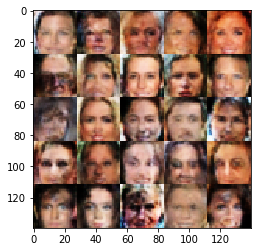

Epoch 1/1 - Batch 5110/6331:  Discriminator Loss: 0.6928 Generator Loss: 1.7645
Epoch 1/1 - Batch 5120/6331:  Discriminator Loss: 0.8218 Generator Loss: 2.1123
Epoch 1/1 - Batch 5130/6331:  Discriminator Loss: 0.8526 Generator Loss: 1.1994
Epoch 1/1 - Batch 5140/6331:  Discriminator Loss: 1.1305 Generator Loss: 0.8667
Epoch 1/1 - Batch 5150/6331:  Discriminator Loss: 0.8444 Generator Loss: 1.6706
Epoch 1/1 - Batch 5160/6331:  Discriminator Loss: 0.8342 Generator Loss: 1.1963
Epoch 1/1 - Batch 5170/6331:  Discriminator Loss: 0.7199 Generator Loss: 2.1363
Epoch 1/1 - Batch 5180/6331:  Discriminator Loss: 0.6834 Generator Loss: 7.8058
Epoch 1/1 - Batch 5190/6331:  Discriminator Loss: 0.9634 Generator Loss: 2.5810
Epoch 1/1 - Batch 5200/6331:  Discriminator Loss: 0.5474 Generator Loss: 4.7416


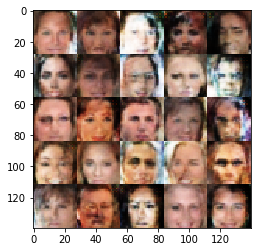

Epoch 1/1 - Batch 5210/6331:  Discriminator Loss: 0.8767 Generator Loss: 1.2377
Epoch 1/1 - Batch 5220/6331:  Discriminator Loss: 0.7583 Generator Loss: 2.0992
Epoch 1/1 - Batch 5230/6331:  Discriminator Loss: 0.7704 Generator Loss: 1.6612
Epoch 1/1 - Batch 5240/6331:  Discriminator Loss: 0.7359 Generator Loss: 1.7236
Epoch 1/1 - Batch 5250/6331:  Discriminator Loss: 0.5421 Generator Loss: 3.3913
Epoch 1/1 - Batch 5260/6331:  Discriminator Loss: 0.9293 Generator Loss: 1.1401
Epoch 1/1 - Batch 5270/6331:  Discriminator Loss: 0.6529 Generator Loss: 1.7194
Epoch 1/1 - Batch 5280/6331:  Discriminator Loss: 0.7760 Generator Loss: 1.7966
Epoch 1/1 - Batch 5290/6331:  Discriminator Loss: 0.7925 Generator Loss: 1.4584
Epoch 1/1 - Batch 5300/6331:  Discriminator Loss: 0.8678 Generator Loss: 1.2801


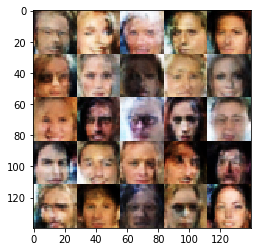

Epoch 1/1 - Batch 5310/6331:  Discriminator Loss: 0.6545 Generator Loss: 2.8266
Epoch 1/1 - Batch 5320/6331:  Discriminator Loss: 0.7366 Generator Loss: 1.4177
Epoch 1/1 - Batch 5330/6331:  Discriminator Loss: 0.8992 Generator Loss: 1.2521
Epoch 1/1 - Batch 5340/6331:  Discriminator Loss: 1.1646 Generator Loss: 3.1640
Epoch 1/1 - Batch 5350/6331:  Discriminator Loss: 0.8650 Generator Loss: 1.2761
Epoch 1/1 - Batch 5360/6331:  Discriminator Loss: 0.7722 Generator Loss: 2.2360
Epoch 1/1 - Batch 5370/6331:  Discriminator Loss: 0.9570 Generator Loss: 1.1120
Epoch 1/1 - Batch 5380/6331:  Discriminator Loss: 1.0371 Generator Loss: 0.8517
Epoch 1/1 - Batch 5390/6331:  Discriminator Loss: 0.8220 Generator Loss: 1.9483
Epoch 1/1 - Batch 5400/6331:  Discriminator Loss: 1.1552 Generator Loss: 2.7202


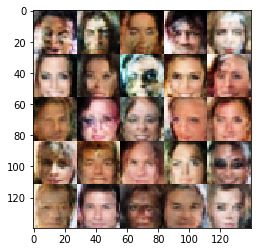

Epoch 1/1 - Batch 5410/6331:  Discriminator Loss: 0.8460 Generator Loss: 1.3340
Epoch 1/1 - Batch 5420/6331:  Discriminator Loss: 0.7667 Generator Loss: 1.3752
Epoch 1/1 - Batch 5430/6331:  Discriminator Loss: 0.8428 Generator Loss: 1.3620
Epoch 1/1 - Batch 5440/6331:  Discriminator Loss: 1.1185 Generator Loss: 2.5693
Epoch 1/1 - Batch 5450/6331:  Discriminator Loss: 0.7336 Generator Loss: 1.7734
Epoch 1/1 - Batch 5460/6331:  Discriminator Loss: 0.9158 Generator Loss: 1.0628
Epoch 1/1 - Batch 5470/6331:  Discriminator Loss: 0.7261 Generator Loss: 1.4317
Epoch 1/1 - Batch 5480/6331:  Discriminator Loss: 1.9670 Generator Loss: 3.0765
Epoch 1/1 - Batch 5490/6331:  Discriminator Loss: 1.0140 Generator Loss: 1.0352
Epoch 1/1 - Batch 5500/6331:  Discriminator Loss: 0.8785 Generator Loss: 1.3627


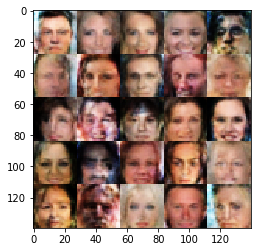

Epoch 1/1 - Batch 5510/6331:  Discriminator Loss: 0.6777 Generator Loss: 1.6777
Epoch 1/1 - Batch 5520/6331:  Discriminator Loss: 0.9329 Generator Loss: 1.1219
Epoch 1/1 - Batch 5530/6331:  Discriminator Loss: 0.9568 Generator Loss: 1.8796
Epoch 1/1 - Batch 5540/6331:  Discriminator Loss: 0.8286 Generator Loss: 1.2014
Epoch 1/1 - Batch 5550/6331:  Discriminator Loss: 0.7167 Generator Loss: 1.6256
Epoch 1/1 - Batch 5560/6331:  Discriminator Loss: 0.8358 Generator Loss: 1.1857
Epoch 1/1 - Batch 5570/6331:  Discriminator Loss: 0.8048 Generator Loss: 1.5602
Epoch 1/1 - Batch 5580/6331:  Discriminator Loss: 1.0035 Generator Loss: 1.1923
Epoch 1/1 - Batch 5590/6331:  Discriminator Loss: 0.9852 Generator Loss: 0.9262
Epoch 1/1 - Batch 5600/6331:  Discriminator Loss: 0.8057 Generator Loss: 1.5399


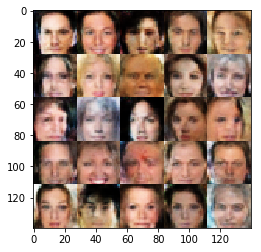

Epoch 1/1 - Batch 5610/6331:  Discriminator Loss: 0.8537 Generator Loss: 1.1434
Epoch 1/1 - Batch 5620/6331:  Discriminator Loss: 1.0687 Generator Loss: 1.7981
Epoch 1/1 - Batch 5630/6331:  Discriminator Loss: 1.0877 Generator Loss: 0.8220
Epoch 1/1 - Batch 5640/6331:  Discriminator Loss: 0.7159 Generator Loss: 2.3677
Epoch 1/1 - Batch 5650/6331:  Discriminator Loss: 1.0023 Generator Loss: 0.8717
Epoch 1/1 - Batch 5660/6331:  Discriminator Loss: 0.6920 Generator Loss: 1.5709
Epoch 1/1 - Batch 5670/6331:  Discriminator Loss: 1.0264 Generator Loss: 1.7400
Epoch 1/1 - Batch 5680/6331:  Discriminator Loss: 1.1298 Generator Loss: 0.8725
Epoch 1/1 - Batch 5690/6331:  Discriminator Loss: 0.8110 Generator Loss: 1.6392
Epoch 1/1 - Batch 5700/6331:  Discriminator Loss: 0.9605 Generator Loss: 1.1686


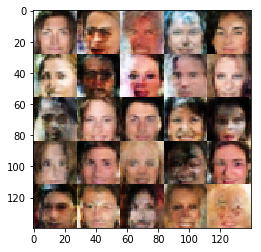

Epoch 1/1 - Batch 5710/6331:  Discriminator Loss: 0.8731 Generator Loss: 1.2990
Epoch 1/1 - Batch 5720/6331:  Discriminator Loss: 0.6713 Generator Loss: 1.8935
Epoch 1/1 - Batch 5730/6331:  Discriminator Loss: 0.7443 Generator Loss: 1.5892
Epoch 1/1 - Batch 5740/6331:  Discriminator Loss: 0.8159 Generator Loss: 1.7000
Epoch 1/1 - Batch 5750/6331:  Discriminator Loss: 1.1398 Generator Loss: 1.0388
Epoch 1/1 - Batch 5760/6331:  Discriminator Loss: 1.2493 Generator Loss: 1.9864
Epoch 1/1 - Batch 5770/6331:  Discriminator Loss: 0.8403 Generator Loss: 1.3914
Epoch 1/1 - Batch 5780/6331:  Discriminator Loss: 0.8530 Generator Loss: 1.0889
Epoch 1/1 - Batch 5790/6331:  Discriminator Loss: 0.8596 Generator Loss: 1.3047
Epoch 1/1 - Batch 5800/6331:  Discriminator Loss: 1.0167 Generator Loss: 0.9059


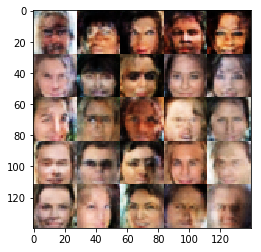

Epoch 1/1 - Batch 5810/6331:  Discriminator Loss: 0.6601 Generator Loss: 1.8575
Epoch 1/1 - Batch 5820/6331:  Discriminator Loss: 0.6742 Generator Loss: 2.2431
Epoch 1/1 - Batch 5830/6331:  Discriminator Loss: 0.9404 Generator Loss: 0.9986
Epoch 1/1 - Batch 5840/6331:  Discriminator Loss: 0.9712 Generator Loss: 0.9815
Epoch 1/1 - Batch 5850/6331:  Discriminator Loss: 0.7789 Generator Loss: 1.4298
Epoch 1/1 - Batch 5860/6331:  Discriminator Loss: 0.7134 Generator Loss: 1.8058
Epoch 1/1 - Batch 5870/6331:  Discriminator Loss: 0.6991 Generator Loss: 1.5894
Epoch 1/1 - Batch 5880/6331:  Discriminator Loss: 0.6201 Generator Loss: 3.5253
Epoch 1/1 - Batch 5890/6331:  Discriminator Loss: 1.0537 Generator Loss: 0.8974
Epoch 1/1 - Batch 5900/6331:  Discriminator Loss: 0.8161 Generator Loss: 1.3492


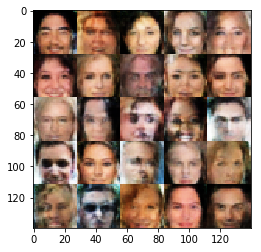

Epoch 1/1 - Batch 5910/6331:  Discriminator Loss: 0.8053 Generator Loss: 1.5301
Epoch 1/1 - Batch 5920/6331:  Discriminator Loss: 0.7459 Generator Loss: 1.5141
Epoch 1/1 - Batch 5930/6331:  Discriminator Loss: 0.9717 Generator Loss: 2.1830
Epoch 1/1 - Batch 5940/6331:  Discriminator Loss: 0.9262 Generator Loss: 1.1726
Epoch 1/1 - Batch 5950/6331:  Discriminator Loss: 1.0349 Generator Loss: 0.8714
Epoch 1/1 - Batch 5960/6331:  Discriminator Loss: 1.0190 Generator Loss: 1.0175
Epoch 1/1 - Batch 5970/6331:  Discriminator Loss: 0.5951 Generator Loss: 4.7215
Epoch 1/1 - Batch 5980/6331:  Discriminator Loss: 0.8781 Generator Loss: 1.2951
Epoch 1/1 - Batch 5990/6331:  Discriminator Loss: 0.7502 Generator Loss: 1.6537
Epoch 1/1 - Batch 6000/6331:  Discriminator Loss: 0.8630 Generator Loss: 1.3844


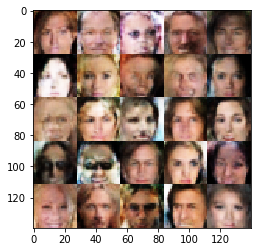

Epoch 1/1 - Batch 6010/6331:  Discriminator Loss: 0.7559 Generator Loss: 1.7633
Epoch 1/1 - Batch 6020/6331:  Discriminator Loss: 0.9610 Generator Loss: 0.9744
Epoch 1/1 - Batch 6030/6331:  Discriminator Loss: 0.6422 Generator Loss: 2.4226
Epoch 1/1 - Batch 6040/6331:  Discriminator Loss: 1.3472 Generator Loss: 2.7118
Epoch 1/1 - Batch 6050/6331:  Discriminator Loss: 1.3019 Generator Loss: 0.6442
Epoch 1/1 - Batch 6060/6331:  Discriminator Loss: 0.7882 Generator Loss: 1.5374
Epoch 1/1 - Batch 6070/6331:  Discriminator Loss: 1.0356 Generator Loss: 1.0899
Epoch 1/1 - Batch 6080/6331:  Discriminator Loss: 1.0810 Generator Loss: 0.8803
Epoch 1/1 - Batch 6090/6331:  Discriminator Loss: 0.7763 Generator Loss: 1.3594
Epoch 1/1 - Batch 6100/6331:  Discriminator Loss: 0.4510 Generator Loss: 6.1139


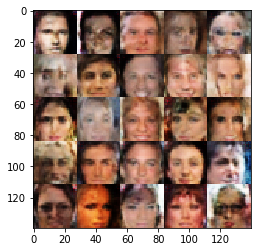

Epoch 1/1 - Batch 6110/6331:  Discriminator Loss: 0.7584 Generator Loss: 1.3219
Epoch 1/1 - Batch 6120/6331:  Discriminator Loss: 0.7278 Generator Loss: 1.7679
Epoch 1/1 - Batch 6130/6331:  Discriminator Loss: 0.8711 Generator Loss: 1.1956
Epoch 1/1 - Batch 6140/6331:  Discriminator Loss: 0.7468 Generator Loss: 2.2001
Epoch 1/1 - Batch 6150/6331:  Discriminator Loss: 0.8759 Generator Loss: 1.1286
Epoch 1/1 - Batch 6160/6331:  Discriminator Loss: 0.9008 Generator Loss: 1.6554
Epoch 1/1 - Batch 6170/6331:  Discriminator Loss: 1.0326 Generator Loss: 1.1229
Epoch 1/1 - Batch 6180/6331:  Discriminator Loss: 0.9127 Generator Loss: 1.0880
Epoch 1/1 - Batch 6190/6331:  Discriminator Loss: 0.7317 Generator Loss: 1.7740
Epoch 1/1 - Batch 6200/6331:  Discriminator Loss: 0.8901 Generator Loss: 1.1793


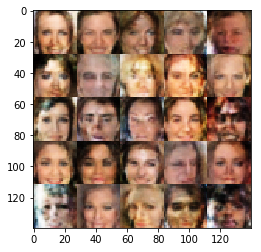

Epoch 1/1 - Batch 6210/6331:  Discriminator Loss: 0.8542 Generator Loss: 1.7634
Epoch 1/1 - Batch 6220/6331:  Discriminator Loss: 0.9369 Generator Loss: 1.0056
Epoch 1/1 - Batch 6230/6331:  Discriminator Loss: 1.2369 Generator Loss: 0.6625
Epoch 1/1 - Batch 6240/6331:  Discriminator Loss: 0.8173 Generator Loss: 1.4796
Epoch 1/1 - Batch 6250/6331:  Discriminator Loss: 1.0210 Generator Loss: 0.9665
Epoch 1/1 - Batch 6260/6331:  Discriminator Loss: 0.6612 Generator Loss: 2.2132
Epoch 1/1 - Batch 6270/6331:  Discriminator Loss: 1.1020 Generator Loss: 0.8774
Epoch 1/1 - Batch 6280/6331:  Discriminator Loss: 0.8592 Generator Loss: 1.7487
Epoch 1/1 - Batch 6290/6331:  Discriminator Loss: 1.0281 Generator Loss: 0.9471
Epoch 1/1 - Batch 6300/6331:  Discriminator Loss: 0.9315 Generator Loss: 1.0446


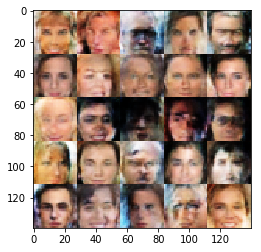

Epoch 1/1 - Batch 6310/6331:  Discriminator Loss: 0.9157 Generator Loss: 3.1360
Epoch 1/1 - Batch 6320/6331:  Discriminator Loss: 1.3497 Generator Loss: 0.6087
Epoch 1/1 - Batch 6330/6331:  Discriminator Loss: 0.9839 Generator Loss: 2.4867


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)